In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from utils_fns import *
from tqdm import tqdm
import time

## Define Gaussian and its derivatives

In [2]:
# Gaussians
def gaussian_nd(x, sigma=1.0):
    """
    Assuming a isotropic gaussian distribution with mean at 0
    Takes x in forms of nxm, where n is the number of samples and m is the dimension
    Returns the gaussian value at each point with shape (n,)
    """
    batch_n, m = x.shape
    sigma2 = sigma ** 2
    norm_squared = torch.sum(x ** 2, dim=1)
    prefactor = 1 / ((2 * torch.pi)**0.5 * sigma)**m
    exp_component = torch.exp(-norm_squared / (2 * sigma2))
    
    return prefactor * exp_component

def calc_gauss(x, mu=0.0, sigma=1.0):
    """
    Michael's 1d gaussian function
    """
    return 1.0 / (sigma * (2.0 * np.pi)**0.5) * torch.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Gaussian gradient
def autograd_gaussian_nd(x, sigma):
    '''
    The gradient of the gaussian function calculated using autograd for checking purposes
    '''
    x = x.clone().detach().requires_grad_(True)
    gauss = gaussian_nd(x, sigma)
    gauss.backward()
    return x.grad

def gauss_grad_1d(x, sigma, *args):
    grad_of_gauss = -(x / sigma ** 2) * calc_gauss(x, mu=0.0, sigma=sigma)
    return grad_of_gauss

def gauss_1d_as_cdf(x, sigma, no_pos=False):
    x = torch.as_tensor(x, dtype=torch.float32)
    before_pos = 0.5 * torch.exp(-0.5 * (x / sigma) ** 2)
    if no_pos:
        return before_pos
    cond = x <= 0
    cdf = torch.where(cond, before_pos, 1-before_pos)
    return cdf

def gauss_grad(x, sigma):
    '''
    Gradient of a nd gaussian function, the dimension is determined by the shape of x
    Takes in a tensor x of shape (n, m), where n is the number of samples and m is the dimension
    Returns the gradient of shape (n, m), where for each sample, each dimension has a gradient
    '''
    return (-x.T / sigma ** 2 * gaussian_nd(x, sigma)).T

def gauss_grad_as_pdf(x, sigma, no_pos=False):
    '''
    Same as gauss grad, but the integral is 1, and positivised so that it is a valid distribution
    returns gradient of shape (n,m), each dimension has a gradient.
    '''
    m = x.shape[-1]
    sigma2 = sigma ** 2
    norm_squared = torch.sum(x ** 2, dim=1)
    prefactor = 1 / ((2 * torch.pi)**0.5 * sigma)**(m-1) # there is one dim need to be 0.5
    # print(prefactor*0.5 * torch.abs(x) / sigma2)
    # print(0.5 * torch.abs(x) / sigma2)
    
    if no_pos:
        prefactor = -prefactor*0.5 * x / sigma2
    else:
        prefactor = prefactor*0.5 * torch.abs(x) / sigma2
    broadcast_dims = x.dim() - 1
    exp_component = torch.exp(-norm_squared / (2 * sigma2)).view(-1, *([1] * broadcast_dims))
    # print(x.shape, exp_component.shape)
    return prefactor * exp_component


def gauss_grad_1d_as_cdf(x, sigma, no_pos=False):
    '''
    The cdf of second order derivative of gaussian, which is gauss grad positivised and normalized to 1
    '''
    x = torch.as_tensor(x, dtype=torch.float32)
    fac = 0.25/sigma * np.exp(0.5)
    grad = -x * torch.exp(-0.5 * (x / sigma) ** 2)
    before_pos = fac*grad
    if no_pos:
        return before_pos
    first0 = x<=-sigma
    second0 = (x > -sigma) & (x <= sigma)
    cdf = torch.where(first0, before_pos, torch.where(second0, 0.5 - before_pos, 1 + before_pos))
        
    return cdf


# For gaussian hessian
def get_combinations(tensor, r=2, replace=False):
    """
    For an input tensor of shape (n, m)
    Return all combinations of r elements for each m element in a row 
    Return as a list of 2d tensors for each row.
    """
    all_combinations = []
    for row in tensor:
        combinations = torch.combinations(row, r, with_replacement=replace)
        all_combinations.append(combinations)
    return all_combinations

def upper_triangle_to_symmetric(x, n):
    '''
    Generate a symmetric matrix from the upper triangle values
    Takes x with shape (n*(n-1)/2,)
    Returns a symmetric matrix of shape (n, n) with diagonal zero
    '''
    mat = torch.zeros((n, n))
    idx = torch.triu_indices(n, n, offset=1)
    mat[idx[0], idx[1]] = x
    
    mat = mat + mat.T
    return mat

def gauss_hessian(x, sigma=1.0):
    '''
    Compute the hessian of a n dimensional isotropic gaussian function with mean at 0
    Takes x in forms of nxm, where n is the number of samples and m is the dimension
    Returns the hessian at each point with shape (n, m, m)
    '''
    
    n_sample, dim = x.shape
    hessians = torch.zeros((n_sample, x.shape[1], x.shape[1]))
    for i, comb in enumerate(get_combinations(x, 2)):
        
        sigma2 = sigma ** 2
        sigma4 = sigma ** 4     
        # diagonals
        diag = torch.diag(x[i]**2/sigma4 - 1/sigma2)
        # non-diagonals
        x1, x2 = comb[:, 0], comb[:, 1]
        
        dxdy = x1*x2/sigma4
        non_diag = upper_triangle_to_symmetric(dxdy, dim)
        
        # hessian
        hessian = (diag + non_diag) * gaussian_nd(x[i].unsqueeze(0), sigma)
        hessians[i] = hessian
    return hessians

def gauss_hessian_fast(x,sigma=1.0):
    '''
    Vectorized version of the gauss_hessian function
    '''
    n_sample, dim = x.shape
    
    hessians = torch.zeros((n_sample, x.shape[1], x.shape[1]))
    sigma2 = sigma ** 2
    sigma4 = sigma ** 4
    # diagonals
    hessians = torch.diag_embed(x**2/sigma4 - 1/sigma2)
    
    # non-diagonals
    x_pairs = get_combinations(x, 2)
    x_pairs = torch.stack(x_pairs, dim=0)
    x1, x2 = x_pairs[:, :, 0], x_pairs[:, :, 1]
    
    dxdy = x1*x2/sigma4
    
    idx = torch.triu_indices(dim, dim, offset=1) # offset = 1 excludes the diagonal
    hessians[:, idx[0], idx[1]] = dxdy
    hessians[:, idx[1], idx[0]] = dxdy
    hessians = hessians * gaussian_nd(x, sigma).view(-1, 1, 1)
    # print('nondiag: ', dxdy * gaussian_nd(x, sigma).view(-1, 1))
    # print('diag: ', diag * gaussian_nd(x, sigma).view(-1, 1, 1))
    return hessians

def gauss_hessian_fastest(x, sigma=1.0):
    '''
    Vectorized version of the gauss_hessian function
    '''
    n_sample, dim = x.shape
    
    hessians = torch.zeros((n_sample, x.shape[1], x.shape[1]))
    sigma2 = sigma ** 2
    sigma4 = sigma ** 4
    
    grid = torch.einsum('ij,ik->ijk', x, x)
    diag_mask = torch.eye(dim, dtype=torch.bool).unsqueeze(0) # get (1,m,m) mask
    diag_mask = diag_mask.repeat(n_sample, 1, 1)
    
    non_diag_mask = ~diag_mask
    # diagonals
    hessians[diag_mask] = grid[diag_mask]/sigma4 - 1/sigma2
    # non-diagonals
    hessians[non_diag_mask] = grid[non_diag_mask]/sigma4
    hessians = hessians * gaussian_nd(x, sigma).view(-1, 1, 1)
    
    return hessians

    
def gauss_hessian_as_pdf(x, sigma):
    '''
    For nxm input of x, each row is a point X in parameter space
    Returns a nxmxm tensor. n number of mxm matrices.
    each i,j element in the mxm matrix is the pdf of the i,j element of the hessian for the given xi and xj value
    (mxm distributions sort of)
    '''
    
    n_sample, m = x.shape
    hessians = torch.zeros((n_sample, x.shape[1], x.shape[1]))
    
    sigma2 = sigma ** 2
    norm_squared = torch.sum(x ** 2, dim=1)
    
    diag_mask = torch.eye(m, dtype=torch.bool).unsqueeze(0) # get (1,m,m) mask
    diag_mask = diag_mask.repeat(n_sample, 1, 1)

    non_diag_mask = ~diag_mask
    # diagonals
    prefactor = 1 / ((2 * torch.pi)**0.5 * sigma)**(m-1) # there is one dim need to be 0.5
    prefactor = prefactor * np.exp(0.5)*((x/sigma)**2 - 1)*0.25/sigma
    first0 = x<=-sigma
    second0 = (x > -sigma) & (x <= sigma)
    hessians[diag_mask] = torch.where(first0, prefactor, torch.where(second0, -prefactor, prefactor)).view(-1)
    
    # non-diagonals
    grid = torch.abs(torch.einsum('ij,ik->ijk', x, x))
    prefactor = 1 / ((2 * torch.pi)**0.5 * sigma)**(m-2) # there are two dims need to be 0.5
    hessians[non_diag_mask] = prefactor * grid[non_diag_mask] * (0.5/sigma2) **2
    
    
    broadcast_dims = hessians.dim() - 1
    exp_component = torch.exp(-norm_squared / (2 * sigma2)).view(-1, *([1] * broadcast_dims))
    hessians = hessians * exp_component

    return hessians

def gauss_hessian_as_pdf_nopos(x, sigma):
    '''
    For nxm input of x, each row is a point X in parameter space
    Returns a nxmxm tensor. n number of mxm matrices.
    each i,j element in the mxm matrix is the pdf of the i,j element of the hessian for the given xi and xj value
    (mxm distributions sort of)
    '''
    
    n_sample, m = x.shape
    hessians = torch.zeros((n_sample, x.shape[1], x.shape[1]))
    
    sigma2 = sigma ** 2
    norm_squared = torch.sum(x ** 2, dim=1)
    
    diag_mask = torch.eye(m, dtype=torch.bool).unsqueeze(0) # get (1,m,m) mask
    diag_mask = diag_mask.repeat(n_sample, 1, 1)

    non_diag_mask = ~diag_mask
    # diagonals
    prefactor = 1 / ((2 * torch.pi)**0.5 * sigma)**(m-1) # there is one dim need to be 0.5
    prefactor = prefactor * np.exp(0.5)*((x/sigma)**2 - 1)*0.25/sigma
    hessians[diag_mask] = prefactor.view(-1)
    
    # non-diagonals
    grid = torch.einsum('ij,ik->ijk', x, x)
    prefactor = 1 / ((2 * torch.pi)**0.5 * sigma)**(m-2) # there are two dims need to be 0.5
    hessians[non_diag_mask] = prefactor * grid[non_diag_mask] * (0.5/sigma2) **2
    
    
    broadcast_dims = hessians.dim() - 1
    exp_component = torch.exp(-norm_squared / (2 * sigma2)).view(-1, *([1] * broadcast_dims))
    hessians = hessians * exp_component

    return hessians

def gauss_hess_diag_as_pdf(x, sigma):
    '''
    For nxm input of x, each row is a point X in parameter space
    The diagonal distribution of hessian of gaussian positivised and integrated to 1
    '''
    m = x.shape[-1]
    sigma2 = sigma ** 2
    norm_squared = torch.sum(x ** 2, dim=1)
    prefactor = 1 / ((2 * torch.pi)**0.5 * sigma)**(m-1) # there is one dim need to be 0.5
    # print(0.25*np.exp(0.5)*((x/sigma)**2 - 1))
    prefactor = prefactor * np.exp(0.5)*((x/sigma)**2 - 1)*0.25

    first0 = x<=-sigma
    second0 = (x > -sigma) & (x <= sigma)
    prefactor = torch.where(first0, prefactor, torch.where(second0, -prefactor, prefactor))
    broadcast_dims = x.dim() - 1
    exp_component = torch.exp(-norm_squared / (2 * sigma2)).view(-1, *([1] * broadcast_dims))
    # print(x.shape, exp_component.shape)
    return prefactor * exp_component

# should be the same as joint dist of two gradient.
def gauss_hess_non_diag_pdf(x, sigma):
    '''
    For nxm input of x, each row is a point X in parameter space
    returns a nxmxm tensor, each mxm's non-diagonal element is the pdf of the non-diagonal element of the hessian
    '''
    m = x.shape[-1]
    sigma2 = sigma ** 2
    norm_squared = torch.sum(x ** 2, dim=1)
    prefactor = 1 / ((2 * torch.pi)**0.5 * sigma)**(m-2) # there are two dims need to be 0.5
    # print(prefactor*0.5 * torch.abs(x) / sigma2)
    # print(0.5 * torch.abs(x) / sigma2)
    grid = torch.abs(torch.einsum('ij,ik->ijk', x, x))
    prefactor = prefactor * grid * (0.5/sigma2) **2

    broadcast_dims = prefactor.dim() - 1
    exp_component = torch.exp(-norm_squared / (2 * sigma2)).view(-1, *([1] * broadcast_dims))
    # print(x.shape, exp_component.shape)
    return prefactor * exp_component


In [3]:
dim=3
n_samples = 2
points = torch.rand(n_samples, dim)  # Example points in 3D space
# points = torch.tensor([[0.5, 0.7, 0.6, 0.8]])
sigma = 1.0

gaussian_values = gaussian_nd(points, sigma)
print("For points {} with sigma {}:".format(points.tolist(), sigma))
print("Values are: ", gaussian_values)

grad_values = gauss_grad_1d(points, sigma)
print("Gradient from Michael's: \n", grad_values)
print("Gradient from mine: \n", gauss_grad(points, sigma))
print("Gradient from autograd: ")
for i in range(n_samples):
    print(autograd_gaussian_nd(points[i].unsqueeze(0), sigma))

hess_values = gauss_hessian(points, sigma)
start = time.time()
print("Hessian from mine: \n", hess_values)
print("Time taken: ", time.time()-start)
start = time.time()
print("Hessian from autograd: ")
for i in range(n_samples):
    point_i = points[i].unsqueeze(0)
    print(torch.autograd.functional.hessian(gaussian_nd, point_i)[0,:,0])
print("Time taken: ", time.time()-start)
start = time.time()
print("Faster hessian: \n", gauss_hessian_fast(points, sigma))
print("Time taken: ", time.time()-start)
start = time.time()
print("Fastest hessian: \n", gauss_hessian_fastest(points, sigma))
print("Time taken: ", time.time()-start)


For points [[0.3444553017616272, 0.8905928134918213, 0.9052150249481201], [0.3890186548233032, 0.9597497582435608, 0.1294095516204834]] with sigma 1.0:
Values are:  tensor([0.0267, 0.0368])
Gradient from Michael's: 
 tensor([[-0.1295, -0.2390, -0.2397],
        [-0.1439, -0.2416, -0.0512]])
Gradient from mine: 
 tensor([[-0.0092, -0.0238, -0.0242],
        [-0.0143, -0.0353, -0.0048]])
Gradient from autograd: 
tensor([[-0.0092, -0.0238, -0.0242]])
tensor([[-0.0143, -0.0353, -0.0048]])
Hessian from mine: 
 tensor([[[-0.0235,  0.0082,  0.0083],
         [ 0.0082, -0.0055,  0.0215],
         [ 0.0083,  0.0215, -0.0048]],

        [[-0.0313,  0.0138,  0.0019],
         [ 0.0138, -0.0029,  0.0046],
         [ 0.0019,  0.0046, -0.0362]]])
Time taken:  0.0004165172576904297
Hessian from autograd: 
tensor([[-0.0235,  0.0082,  0.0083],
        [ 0.0082, -0.0055,  0.0215],
        [ 0.0083,  0.0215, -0.0048]])
tensor([[-0.0313,  0.0138,  0.0019],
        [ 0.0138, -0.0029,  0.0046],
        [ 0.

## Define convolution with the gaussian and derivatives of gaussian

### Define sampling methods

In [4]:
# Samplers
def uniform(n_samples, dim, min=-1.0, max=1.0):
    '''
    min, max are the same for all dims
    '''
    eps = 0.00001
    samples = torch.rand(int(n_samples), dim)
    # samples[torch.isclose(samples, torch.ones_like(samples))] -= eps
    # samples[torch.isclose(samples, torch.zeros_like(samples))] += eps
    samples = min+(max-min)*samples
    
    return samples, 1/((max-min)**dim)

def grid(n_samples, dim, min, max):
    '''
    min, max are the same for all dims
    '''
    eps = 0.00001
    size = int(n_samples ** (1/dim))
    grid = torch.linspace(min, max, size)
    grid = torch.meshgrid([grid] * dim, indexing='ij')
    grid = torch.stack(grid, dim=-1).view(-1, dim)
    # grid[torch.isclose(grid, torch.ones_like(grid))] -= eps
    # grid[torch.isclose(grid, torch.zeros_like(grid))] += eps
    return size**2, grid, 1/((max-min)**dim)

def importance_gradgauss(n_samples, dim, sigma, is_antithetic, pdf=False):
    '''
    Michael's grad gauss IS sampler, now slightly changed for 1d grad gauss
    '''
    eps = 0.00001
    randoms = torch.rand(n_samples, dim)

    def icdf(x, sigma):
        res = torch.zeros_like(x)
        res[mask == 1] = torch.sqrt(-2.0 * sigma ** 2 * torch.log(2.0 * (1.0 - x[mask == 1])))
        res[mask == -1] = torch.sqrt(-2.0 * sigma ** 2 * torch.log(2.0 * x[mask == -1]))
        return res

    # samples and AT samples
    if is_antithetic:
        randoms = torch.cat([randoms, 1.0 - randoms])
        n_samples = n_samples * 2

    # avoid NaNs bc of numerical instabilities in log
    randoms[torch.isclose(randoms, torch.ones_like(randoms))] -= eps
    randoms[torch.isclose(randoms, torch.zeros_like(randoms))] += eps
    randoms[torch.isclose(randoms, torch.full_like(randoms, fill_value=0.5))] += eps
    randoms[torch.isclose(randoms, torch.full_like(randoms, fill_value=-0.5))] -= eps

    mask = torch.where(randoms < 0.5, -1.0, 1.0)
    x_i = icdf(randoms, sigma=sigma) * mask
    
    p_xi = 1
    if pdf:
        f_xi = torch.abs(x_i) * (1.0 / sigma ** 2) * calc_gauss(x_i, mu=0.0, sigma=sigma)
        f_xi[f_xi == 0] += eps
        p_xi = 0.5 * sigma * (2.0 * np.pi)**0.5 * f_xi

    return n_samples, x_i, p_xi


def importance_gauss_nd(n_samples, dim, sigma, is_antithetic=True, pdf=False):
    '''
    Returns a importance sampled points from nd gaussian 
    with shape (nsamples, dim)
    '''
    eps = 0.00001
    randoms = torch.rand(n_samples, dim)
    normal_dist = torch.distributions.normal.Normal(0, sigma)

    # samples and AT samples
    if is_antithetic:
        randoms = torch.cat([randoms, 1.0 - randoms])
        n_samples = n_samples * 2

    # avoid NaNs bc of numerical instabilities in log
    randoms[torch.isclose(randoms, torch.ones_like(randoms))] -= eps
    randoms[torch.isclose(randoms, torch.zeros_like(randoms))] += eps
    
    x_i = normal_dist.icdf(randoms)
    p_xi=1
    if pdf:
        p_xi = normal_dist.log_prob(x_i).exp()

    return n_samples, x_i, p_xi

def importance_gradgauss_nd(n_samples, dim, sigma, is_antithetic=True, dir=0):
    '''
    Dim is the dimension of tau (x)
    dir is the direction number (which gradient) x:0, y:1, ...
    '''
    assert dim >= 1
    gauss_dim = dim-1
    _, x_i, _ = importance_gradgauss(n_samples, dim=1, sigma=sigma, is_antithetic=is_antithetic)
    if gauss_dim>0:
        _, x_otherdims, _ = importance_gauss_nd(n_samples, gauss_dim, sigma, is_antithetic)
        x_before = x_otherdims[:, :dir]
        x_after = x_otherdims[:, dir:]
        x_i = torch.cat((x_before, x_i, x_after), dim=1)
    if is_antithetic:
        n_samples *= 2
    p_x = gauss_grad_as_pdf(x_i, sigma=sigma)

    return n_samples, x_i, p_x


def inverse_cdf_hess(sigma):
    x_range = torch.linspace(-10*sigma, 10*sigma, 2000)
    y_range = gauss_grad_1d_as_cdf(x_range, sigma)
    def interpolation(y):
        return torch.as_tensor(np.interp(y, y_range, x_range), dtype=torch.float32)
    return interpolation

def importance_hessgauss(n_samples, dim, sigma, is_antithetic):
    '''
    Only for the diagonals, so dim is always 1 (2ND ORDER DERIVATIVE)
    '''
    eps = 0.0001
    
    randoms = torch.rand(n_samples, dim)
    icdf = inverse_cdf_hess(sigma)

    # samples and AT samples
    if is_antithetic:
        randoms = torch.cat([randoms, 1.0 - randoms])
        n_samples = n_samples * 2

    # avoid NaNs bc of numerical instabilities in log
    randoms[torch.isclose(randoms, torch.ones_like(randoms))] -= eps
    randoms[torch.isclose(randoms, torch.zeros_like(randoms))] += eps
    randoms[torch.isclose(randoms, torch.full_like(randoms, fill_value=0.25))] += eps
    randoms[torch.isclose(randoms, torch.full_like(randoms, fill_value=0.75))] -= eps

    x_i = icdf(randoms)
    
    return n_samples, x_i

def importance_hessgauss_nd(n_samples, dim, sigma, is_antithetic=True, dir=(0,0)):
    '''
    Dim is dimension of tau (x) which is same as parameter space
    dir is the combination of direction. (i,j) means the partial derivative of the ith and jth dimensions
    Diagonal is interpolated result, non-diagonal is two gradgauss samples
    '''
    assert dim >= 1
    
    i, j = dir
    assert i < dim and j < dim, f"hessian entry {i},{j} is out of bounds for dim {dim}"
    
    if i == j: # for diagonals
        gauss_dim = dim-1
        _, x_i = importance_hessgauss(n_samples, dim=1, sigma=sigma, is_antithetic=is_antithetic)
        if gauss_dim>0:
            _, x_otherdims, _ = importance_gauss_nd(n_samples, gauss_dim, sigma, is_antithetic)
            x_before = x_otherdims[:, :i]
            x_after = x_otherdims[:, i:]
            x_i = torch.cat((x_before, x_i, x_after), dim=1)
    else: # non diagonal is same as 2 grad gauss
        gauss_dim = dim-2
        _, x_i, _ = importance_gradgauss(n_samples, dim=1, sigma=sigma, is_antithetic=is_antithetic)
        _, x_j, _ = importance_gradgauss(n_samples, dim=1, sigma=sigma, is_antithetic=is_antithetic)
        if gauss_dim>0:
            _, x_otherdims, _ = importance_gauss_nd(n_samples, gauss_dim, sigma, is_antithetic)
            i, j = min(i, j), max(i, j)
            x_before_i = x_otherdims[:, :i]
            x_between_ij = x_otherdims[:, i:j]
            x_after_j = x_otherdims[:, j:]
            x_i = torch.cat((x_before_i, x_i, x_between_ij, x_j, x_after_j), dim=1)
        else:
            x_i = torch.cat((x_i, x_j), dim=1)
        
    if is_antithetic:
        n_samples *= 2
    p_x = gauss_hessian_as_pdf(x_i, sigma=sigma)

    return n_samples, x_i, p_x

    

def mc_estimate(f_xi, p_xi, n):
    '''
    n is the number of samplers
    f_xi should be with shape (n,...)
    '''
    
    estimate = 1. / n * (f_xi / p_xi).sum(axis=0)  # average along batch axis, leave dimension axis unchanged
    return estimate

### Define convolution

In [5]:

# convolution
def convolve(f, kernel, point, n, sampler='uniform', f_args={}, kernel_args={}, sampler_args={}):
    """
    Convolves a function with a kernel
    The function f should take in a tensor of shape (n, m) and return a tensor of shape (n,)
    The kernel should also take in a tensor of shape (n, m) and return a tensor of shape (n, ...)
    Point should be a tensor of shape (1,m), which is a single point with same dimension as the input of f and kernel
    n is the number of samples around the input point to be sampled
    sampler can be: 'uniform', 'grid', 'importance_gradgauss', 'importance_hessgauss'
    
    Returns the result with the shape same as output of the kernel
    """
    
    dims = point.shape[1]
    
    # determine the sampler
    if sampler == 'uniform':
        tau, pdf = uniform(n, dims, **sampler_args)
    elif sampler == 'grid':
        # changes n to nearest square number
        n, tau, pdf = grid(n, dims, **sampler_args)
    elif sampler == 'importance_gradgauss':
        n, tau, pdf = importance_gradgauss_nd(n, dims, **sampler_args)
    elif sampler == 'importance_hessgauss':
        n, tau, pdf = importance_hessgauss_nd(n, dims, **sampler_args)
        
    # shift samples around current parameter
    points = torch.cat([point] * n, dim=0) - tau
    f_values = f(points, **f_args)
    weights = kernel(x=tau, **kernel_args)
    
    # weights can be (n, ...), generating (...) of convolutions
    broadcast_dims = weights.dim() - 1
    f_values = f_values.view(-1, *([1] * broadcast_dims))
    
    # mc_estimate 
    # convolved_value = (weights * f_values).sum(axis=0)/weights.sum(axis=0)
    # print(sampler)
    # if sampler == 'importance_gradgauss':
    #     print("num: ", (weights*f_values).shape)
    #     print("pdf: ", pdf.shape)
    convolved_value = mc_estimate(weights * f_values, pdf, n)
    
    return convolved_value


n_samples = 1000
points = torch.tensor([[0.1, 0.9]])
sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}
# usage examples
# 1d
print("Value: ")
sampled_res = convolve(gaussian_nd, gaussian_nd, points[0].unsqueeze(0), n=n_samples, 
                       sampler='uniform', f_args=f_args, kernel_args=kernel_args, sampler_args={})

res = gaussian_nd(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# 2x1, grid
print("\nGrad: ")
sampler_args = {'min': 0.1, 'max': 0.9}
sampled_res = convolve(gaussian_nd, gauss_grad, points[0].unsqueeze(0),  n=n_samples, 
                       sampler='grid', f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args)

res = gauss_grad(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# 2x2
print("\nHessian: ")
sampled_res = convolve(gaussian_nd, gauss_hessian, points[0].unsqueeze(0),  n=n_samples, 
                       sampler='uniform', f_args=f_args, kernel_args=kernel_args)

res = gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)


Value: 
Sampled the convolution result:
tensor(1.1398e-08)
True result: 
tensor([9.9484e-09])

Grad: 
Sampled the convolution result:
tensor([-3.7097e-08, -1.2618e-07])
True result: 
tensor([[-4.9742e-08, -4.4768e-07]])

Hessian: 
Sampled the convolution result:
tensor([[-1.8552e-07,  1.8345e-06],
        [ 1.8345e-06,  1.5564e-05]])
True result: 
tensor([[[-2.4871e-07,  2.2384e-06],
         [ 2.2384e-06,  1.9648e-05]]])


## Test convolution on gaussian 

### Gaussian itself

In [9]:
# sigma1 is the gaussian as the 'function', sigma2 is the convolution kernel (doesn't really matter)
sigma1, sigma2 = 0.1, 0.1

grid_size = 100
x1 = np.linspace(-0.3, 0.3, grid_size)
x2 = np.linspace(-0.3, 0.3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)

#gauss
y = gaussian_nd(torch.tensor(x), sigma1).reshape((grid_size,grid_size))

#grad
grad = gauss_grad(torch.tensor(x, dtype=torch.float32), sigma1)
y0, y1 = grad[:,0].reshape((grid_size,grid_size)), grad[:,1].reshape((grid_size,grid_size))

#Hess
hess_non_diag = gauss_hessian(torch.tensor(x, dtype=torch.float32), sigma1)
y00, y01, y11 = hess_non_diag[:,0,0].reshape((grid_size,grid_size)), hess_non_diag[:,0,1].reshape((grid_size,grid_size)), hess_non_diag[:,1,1].reshape((grid_size,grid_size))

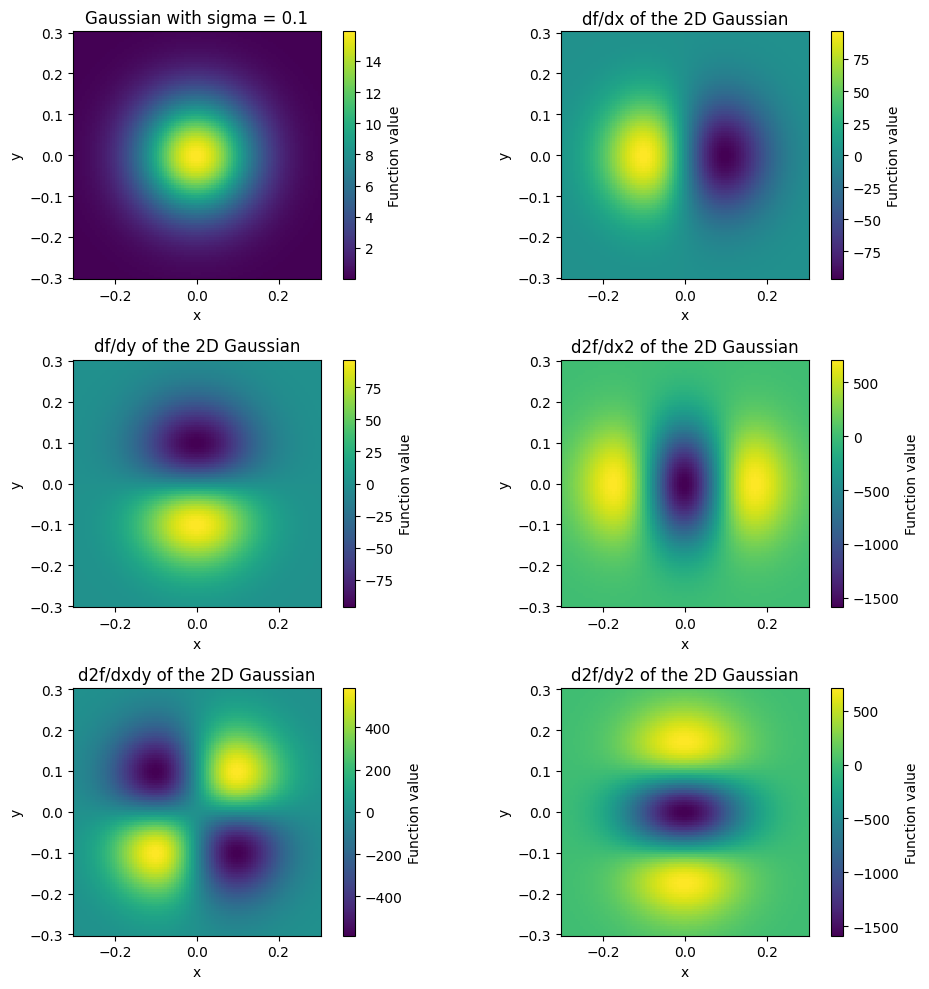

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

cur_ax = ax[0,0]
pcm = cur_ax.pcolor(X1, X2, y)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('Gaussian with sigma = {}'.format(sigma1))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[0,1]
pcm = cur_ax.pcolor(X1, X2, y0)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dx of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1,0]
pcm = cur_ax.pcolor(X1, X2, y1)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dy of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1,1]
pcm = cur_ax.pcolor(X1, X2, y00)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dx2 of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[2,0]
pcm = cur_ax.pcolor(X1, X2, y01)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dxdy of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[2,1]
pcm = cur_ax.pcolor(X1, X2, y11)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dy2 of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### Analytical convolved gaussian by itself

In [7]:
new_sigma = (sigma1**2 + sigma2**2)**0.5

# convolution value
y = gaussian_nd(torch.tensor(x), new_sigma).reshape((grid_size,grid_size))

# covolution grad
grad = gauss_grad(torch.tensor(x, dtype=torch.float32), new_sigma)
y0, y1 = grad[:,0].reshape((grid_size,grid_size)), grad[:,1].reshape((grid_size,grid_size))

# convolution hess
hess_non_diag = gauss_hessian(torch.tensor(x, dtype=torch.float32), new_sigma)
y00, y01, y11 = hess_non_diag[:,0,0].reshape((grid_size,grid_size)), hess_non_diag[:,0,1].reshape((grid_size,grid_size)), hess_non_diag[:,1,1].reshape((grid_size,grid_size))

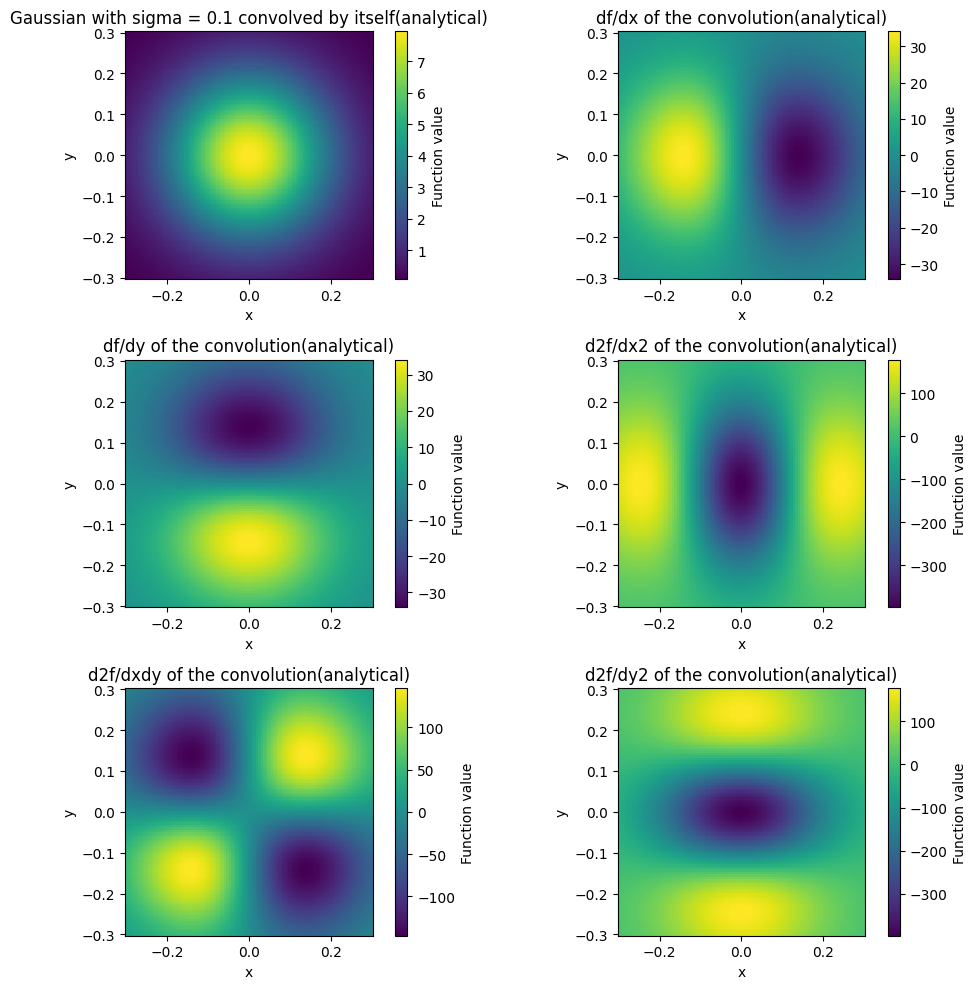

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

cur_ax = ax[0,0]
pcm = cur_ax.pcolor(X1, X2, y)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('Gaussian with sigma = {} convolved by itself(analytical)'.format(sigma1))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[0,1]
pcm = cur_ax.pcolor(X1, X2, y0)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dx of the convolution(analytical)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1,0]
pcm = cur_ax.pcolor(X1, X2, y1)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dy of the convolution(analytical)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1,1]
pcm = cur_ax.pcolor(X1, X2, y00)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dx2 of the convolution(analytical)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[2,0]
pcm = cur_ax.pcolor(X1, X2, y01)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dxdy of the convolution(analytical)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[2,1]
pcm = cur_ax.pcolor(X1, X2, y11)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dy2 of the convolution(analytical)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### Sampled convolved gaussian by itself

In [11]:
# Sampled convolution results
n_samples=1000
sampler = 'uniform'
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}
print("With sigma1 = {} and sigma2 = {}".format(sigma1, sigma2))
sampler_args = {'min': -1, 'max': 1}

y = np.zeros(grid_size*grid_size)
for i, point in enumerate(tqdm(x)):
    convolved_value = convolve(gaussian_nd, gaussian_nd, torch.tensor(point, dtype=torch.float32).unsqueeze(0), n=n_samples, 
                                sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args)
    y[i] = convolved_value.detach().numpy()
y = y.reshape((grid_size,grid_size))

# sampled gradient
sampler = 'importance_gradgauss'
grad = np.zeros((grid_size*grid_size, 2))
for i, point in enumerate(tqdm(x)):
    sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir': 0}
    convolved_value = convolve(gaussian_nd, gauss_grad, torch.tensor(point, dtype=torch.float32).unsqueeze(0), n=n_samples, 
                                sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args)[0]
    grad[i, 0] = convolved_value.detach().numpy()
    sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir': 1}
    convolved_value = convolve(gaussian_nd, gauss_grad, torch.tensor(point, dtype=torch.float32).unsqueeze(0), n=n_samples, 
                                sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args)[1]
    grad[i, 1] = convolved_value.detach().numpy()
y0 = grad[:,0].reshape((grid_size,grid_size))
y1 = grad[:,1].reshape((grid_size,grid_size))

With sigma1 = 0.1 and sigma2 = 0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:32<00:00, 311.15it/s]


In [9]:
# Sampled hessian
hess_non_diag = np.zeros((grid_size*grid_size, 2, 2))
for i, point in enumerate(tqdm(x)):
    convolved_value = convolve(gaussian_nd, gauss_hessian_fast, torch.tensor(point, dtype=torch.float32).unsqueeze(0), n=n_samples, 
                                sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args)
    hess_non_diag[i] = convolved_value.detach().numpy()

y00 = hess_non_diag[:,0,0].reshape((grid_size,grid_size))
y01 = hess_non_diag[:,1,0].reshape((grid_size,grid_size))
y11 = hess_non_diag[:,1,1].reshape((grid_size,grid_size))

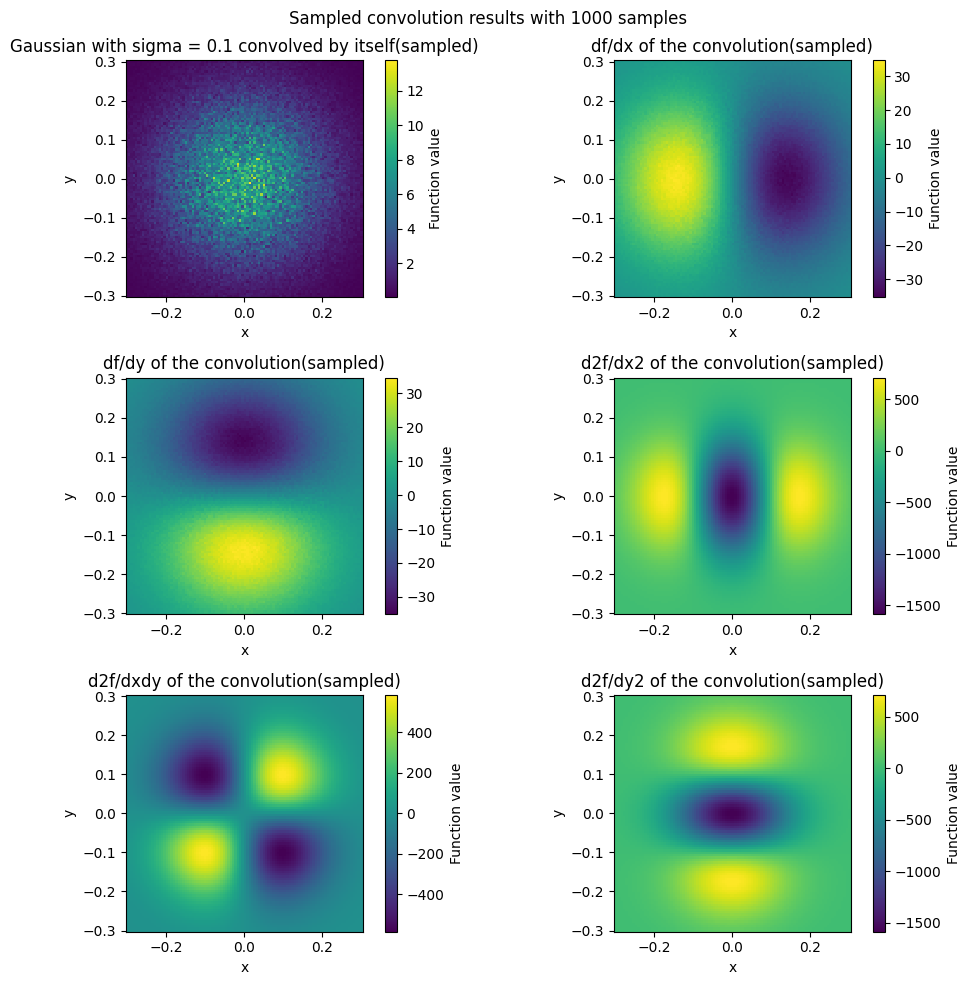

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

cur_ax = ax[0,0]
pcm = cur_ax.pcolor(X1, X2, y)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('Gaussian with sigma = {} convolved by itself(sampled)'.format(sigma1))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[0,1]
pcm = cur_ax.pcolor(X1, X2, y0)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dx of the convolution(sampled)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1,0]
pcm = cur_ax.pcolor(X1, X2, y1)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dy of the convolution(sampled)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

# hessian
cur_ax = ax[1,1]
pcm = cur_ax.pcolor(X1, X2, y00)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dx2 of the convolution(sampled)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[2,0]
pcm = cur_ax.pcolor(X1, X2, y01)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dxdy of the convolution(sampled)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[2,1]
pcm = cur_ax.pcolor(X1, X2, y11)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('d2f/dy2 of the convolution(sampled)')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

fig.suptitle('Sampled convolution results with {} samples'.format(n_samples))
plt.tight_layout()
plt.show()


### Testing importance sampling

/tmp/ipykernel_53442/3646408280.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  cur_ax.legend()


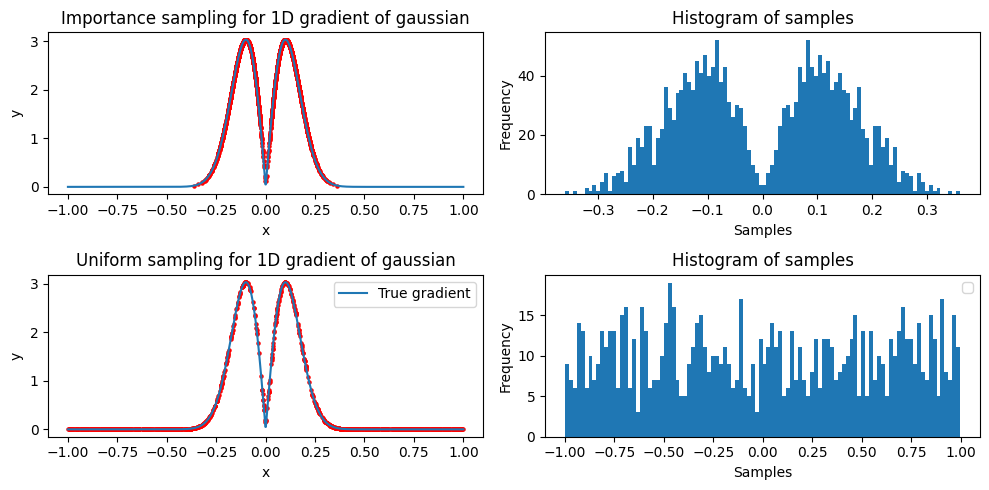

In [10]:
# Showing importance samples
# 1d
n_samples = 1000
x_range = np.linspace(-1, 1, n_samples)
x_range_torch = torch.tensor(x_range, dtype=torch.float32)
gauss_grad_shape = gauss_grad_as_pdf(x_range_torch.unsqueeze(1), sigma1) # get the s shape
n, tau, pdf = importance_gradgauss_nd(n_samples, 1, sigma=sigma1, is_antithetic=True) # get the samples
gauss_grad_values = gauss_grad_as_pdf(tau, sigma1) # get the samples corresponding y values
# print(tau.shape, gauss_grad_values.shape)
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

cur_ax = ax[0,0]
cur_ax.plot(x_range, gauss_grad_shape, label='True gradient')
cur_ax.scatter(tau, gauss_grad_values, s=5, color='red')
cur_ax.set_title("Importance sampling for 1D gradient of gaussian")
cur_ax.set_xlabel("x")
cur_ax.set_ylabel("y")

cur_ax = ax[0,1]
cur_ax.hist(tau, bins=100)
cur_ax.set_title("Histogram of samples")
cur_ax.set_ylabel("Frequency")
cur_ax.set_xlabel("Samples")

tau, pdf = uniform(n_samples, 1, min=-1, max=1)
gauss_grad_values = gauss_grad_as_pdf(tau, sigma1) # get the samples corresponding y values

cur_ax = ax[1,0]
cur_ax.plot(x_range, gauss_grad_shape, label='True gradient')
cur_ax.scatter(tau, gauss_grad_values, s=5, color='red')
cur_ax.set_title("Uniform sampling for 1D gradient of gaussian")
cur_ax.set_xlabel("x")
cur_ax.set_ylabel("y")
cur_ax.legend()

cur_ax = ax[1,1]
cur_ax.hist(tau, bins=100)
cur_ax.set_title("Histogram of samples")
cur_ax.set_ylabel("Frequency")
cur_ax.set_xlabel("Samples")
cur_ax.legend()

fig.tight_layout()
plt.show()


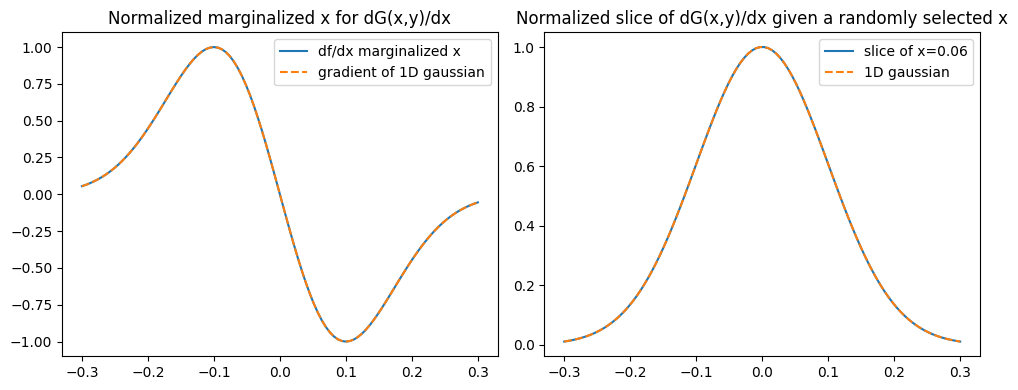

In [11]:
# marginalize
def normalize(x):
    return x / x.max()
  
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
margin_x = normalize(y0.sum(axis=0))
grad_1d = normalize(gauss_grad_1d(torch.tensor(x1, dtype=torch.float32), sigma=sigma1))
cur_ax = ax[0]
cur_ax.plot(x1, margin_x, label='df/dx marginalized x')
cur_ax.plot(x1, grad_1d, label='gradient of 1D gaussian', linestyle='--')
cur_ax.legend()
cur_ax.set_title("Normalized marginalized x for dG(x,y)/dx")
fig.tight_layout()

cur_ax = ax[1] 
rng = np.random.default_rng()
random_x = rng.choice(len(x1))
gauss_1d = normalize(calc_gauss(torch.tensor(x1, dtype=torch.float32), sigma=sigma1))
sliced_gauss = normalize(y0[:, rng.choice(len(x1))])
cur_ax.plot(x1, sliced_gauss, label='slice of x={:.2f}'.format(x1[random_x]))
cur_ax.plot(x1, gauss_1d, label='1D gaussian', linestyle='--')
cur_ax.set_title("Normalized slice of dG(x,y)/dx given a randomly selected x")
cur_ax.legend()
fig.tight_layout()


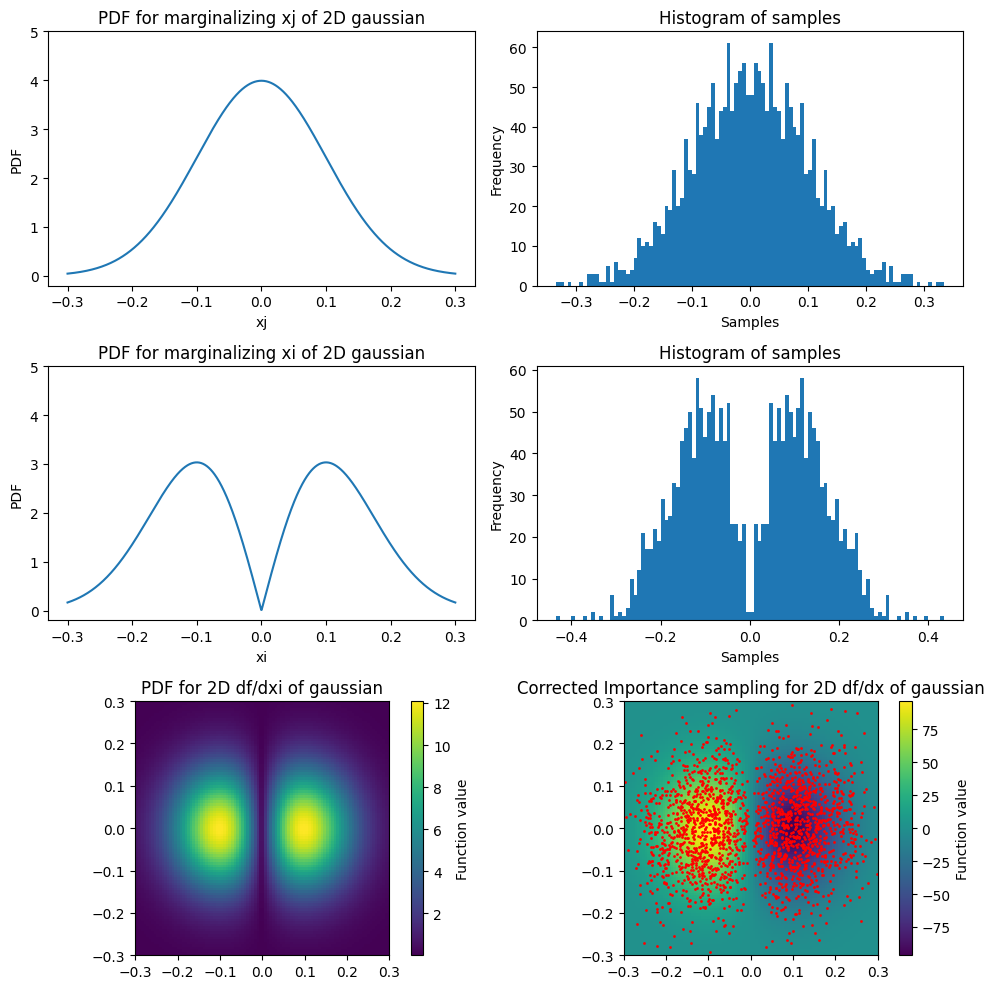

In [12]:
# true IS in 2D
n_samples = 1000
x_range = np.linspace(-0.3, 0.3, n_samples)
gauss_shape = calc_gauss(torch.tensor(x_range, dtype=torch.float32), mu=0, sigma=sigma1) # get the s shape
# gauss_shape = gauss_1d_as_cdf(torch.tensor(x_range, dtype=torch.float32), sigma=sigma1, no_pos=True)
n, tau1, pdf = importance_gauss_nd(n_samples, dim=1, sigma=sigma1, is_antithetic=True) # get the samples
gauss_values = calc_gauss(tau1, mu=0, sigma=sigma1) # get the samples corresponding y values

fig, ax = plt.subplots(3, 2, figsize=(10, 10))

cur_ax = ax[0,0]
cur_ax.plot(x_range, gauss_shape, label='True gradient')
# cur_ax.scatter(tau1, gauss_values, s=5, color='red')
cur_ax.set_title("PDF for marginalizing xj of 2D gaussian")
cur_ax.set_xlabel("xj")
cur_ax.set_ylabel("PDF")
cur_ax.set_ylim((-0.2, 5))

cur_ax = ax[0,1]
cur_ax.hist(tau1, bins=100)
cur_ax.set_title("Histogram of samples")
cur_ax.set_ylabel("Frequency")
cur_ax.set_xlabel("Samples")

# continue to the next dim
# gauss_grad_shape = gauss_grad_1d(torch.tensor(x_range, dtype=torch.float32), sigma1) # get the s shape
gauss_grad_shape = gauss_grad_as_pdf(torch.tensor(x_range, dtype=torch.float32).unsqueeze(1), sigma=sigma1)
n, tau2, pdf = importance_gradgauss(n_samples, 1, sigma=sigma1, is_antithetic=True) # get the samples
gauss_grad_values = gauss_grad_1d(tau2, sigma1) # get the samples corresponding y values
cur_ax = ax[1,0]
cur_ax.plot(x_range, gauss_grad_shape, label='True gradient')
# cur_ax.scatter(tau2, gauss_grad_values, s=5, color='red')
cur_ax.set_title("PDF for marginalizing xi of 2D gaussian")
cur_ax.set_xlabel("xi")
cur_ax.set_ylabel("PDF")
cur_ax.set_ylim((-0.2, 5))

cur_ax = ax[1,1]
cur_ax.hist(tau2, bins=100)
cur_ax.set_title("Histogram of samples")
cur_ax.set_ylabel("Frequency")
cur_ax.set_xlabel("Samples")

# combine two dims
grad_gauss_shape_2d = gauss_grad_as_pdf(torch.tensor(x, dtype=torch.float32), sigma=sigma1)[:,0].reshape((grid_size,grid_size))
tau_2d = torch.stack([tau1, tau2], dim=1)
cur_ax = ax[2,0]
pcm = cur_ax.pcolor(X1, X2, grad_gauss_shape_2d)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
# cur_ax.scatter(tau_2d[:,0], tau_2d[:,1], s=1, color='red')
cur_ax.set_xlim(-0.3, 0.3)
cur_ax.set_ylim(-0.3, 0.3)
cur_ax.set_aspect('equal', adjustable='box')
cur_ax.set_title('PDF for 2D df/dxi of gaussian')

tau_2d = torch.stack([tau2, tau1], dim=1)
cur_ax = ax[2,1]
pcm = cur_ax.pcolor(X1, X2, y0)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.scatter(tau_2d[:,0], tau_2d[:,1], s=1, color='red')
cur_ax.set_xlim(-0.3, 0.3)
cur_ax.set_ylim(-0.3, 0.3)
cur_ax.set_aspect('equal', adjustable='box')
cur_ax.set_title('Corrected Importance sampling for 2D df/dx of gaussian')



fig.tight_layout()

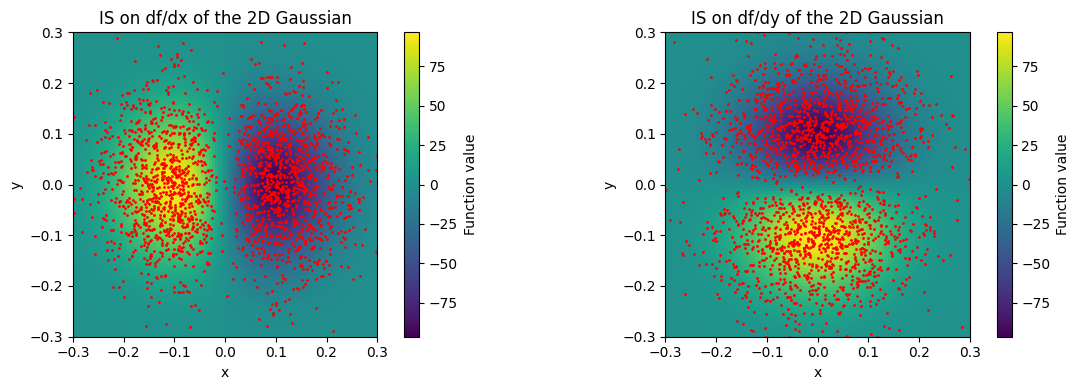

In [16]:
# 2d
n_samples = 1000
n, tau_x, pdf = importance_gradgauss_nd(n_samples, 2, sigma=sigma1, is_antithetic=True, dir=0) # get the samples
n, tau_y, pdf = importance_gradgauss_nd(n_samples, 2, sigma=sigma1, is_antithetic=True, dir=1)

#grad
grad = gauss_grad(torch.tensor(x, dtype=torch.float32), sigma1)
y0, y1 = grad[:,0].reshape((grid_size,grid_size)), grad[:,1].reshape((grid_size,grid_size))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

cur_ax = ax[0]
pcm = cur_ax.pcolor(X1, X2, y0)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.scatter(tau_x[:,0], tau_x[:,1],s=1, color='red')
cur_ax.set_title('IS on df/dx of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_xlim(-0.3, 0.3)
cur_ax.set_ylim(-0.3, 0.3)
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1]
pcm = cur_ax.pcolor(X1, X2, y1)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.scatter(tau_y[:,0], tau_y[:,1],s=1, color='red')
cur_ax.set_title('IS on df/dy of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_xlim(-0.3, 0.3)
cur_ax.set_ylim(-0.3, 0.3)
cur_ax.set_aspect('equal', adjustable='box')

np.save('./results/samples/grad_dx_sampels.npy', tau_x)
np.save('./results/samples/grad_dy_samples.npy', tau_y)
np.save('./results/samples/grad_dx_image.npy', y0)
np.save('./results/samples/grad_dy_image.npy', y1)
fig.tight_layout()

Hessian

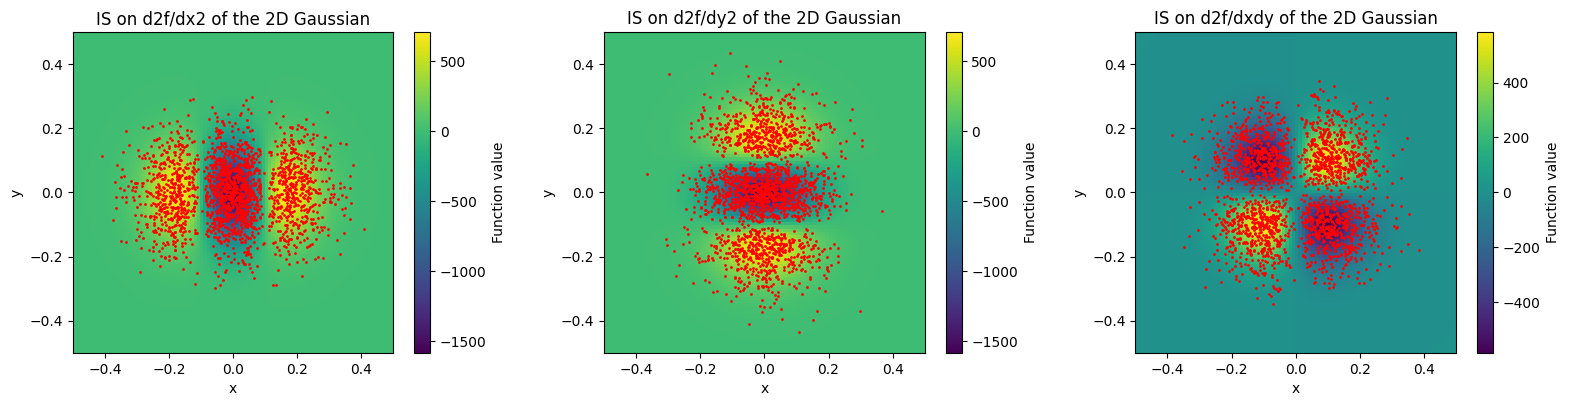

In [18]:
# 2d
n_samples = 1000
n, tau_x, pdf = importance_hessgauss_nd(n_samples, 2, sigma=sigma1, is_antithetic=True, dir=(0,0)) # get the samples
n, tau_y, pdf = importance_hessgauss_nd(n_samples, 2, sigma=sigma1, is_antithetic=True, dir=(1,1))
n, tau_xy, pdf = importance_hessgauss_nd(n_samples, 2, sigma=sigma1, is_antithetic=True, dir=(0,1))

#Hess
grid_size = 100
x1 = np.linspace(-0.5, 0.5, grid_size)
x2 = np.linspace(-0.5, 0.5, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
hessian = gauss_hessian(torch.tensor(x, dtype=torch.float32), sigma1)
y00, y01, y11 = hessian[:,0,0].reshape((grid_size,grid_size)), hessian[:,0,1].reshape((grid_size,grid_size)), hessian[:,1,1].reshape((grid_size,grid_size))

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

cur_ax = ax[0]
pcm = cur_ax.pcolor(X1, X2, y00)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.scatter(tau_x[:,0], tau_x[:,1],s=1, color='red')
cur_ax.set_title('IS on d2f/dx2 of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_xlim(-0.5, 0.5)
cur_ax.set_ylim(-0.5, 0.5)
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1]
pcm = cur_ax.pcolor(X1, X2, y11)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.scatter(tau_y[:,0], tau_y[:,1],s=1, color='red')
cur_ax.set_title('IS on d2f/dy2 of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_xlim(-0.5, 0.5)
cur_ax.set_ylim(-0.5, 0.5)
cur_ax.set_aspect('equal', adjustable='box')

cur_ax = ax[2]
pcm = cur_ax.pcolor(X1, X2, y01)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.scatter(tau_xy[:,0], tau_xy[:,1],s=1, color='red')
cur_ax.set_title('IS on d2f/dxdy of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_xlim(-0.5, 0.5)
cur_ax.set_ylim(-0.5, 0.5)
cur_ax.set_aspect('equal', adjustable='box')

np.save('./results/samples/hess_dx2_samples.npy', tau_x)
np.save('./results/samples/hess_dy2_samples.npy', tau_y)
np.save('./results/samples/hess_dxdy_samples.npy', tau_xy)
np.save('./results/samples/hess_dx2_image.npy', y00)
np.save('./results/samples/hess_dy2_image.npy', y11)
np.save('./results/samples/hess_dxdy_image.npy', y01)
fig.tight_layout()

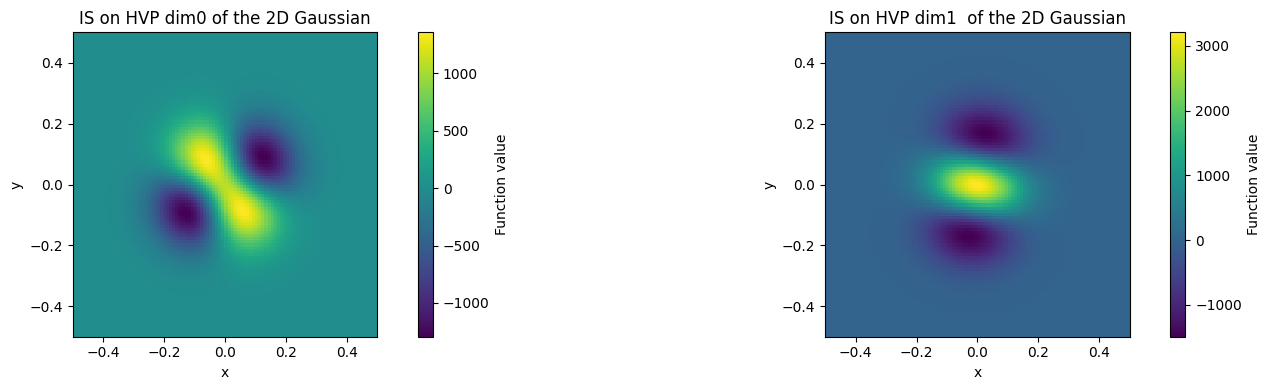

In [24]:
# 2d
# n_samples = 1000
# n, tau_x, pdf = importance_hessgauss_nd(n_samples, 2, sigma=sigma1, is_antithetic=True, dir=(0,0)) # get the samples
# n, tau_y, pdf = importance_hessgauss_nd(n_samples, 2, sigma=sigma1, is_antithetic=True, dir=(1,1))
# n, tau_xy, pdf = importance_hessgauss_nd(n_samples, 2, sigma=sigma1, is_antithetic=True, dir=(0,1))

random_vec = torch.randn(2)
HVP0 = y00 * random_vec[0] + y01 * random_vec[1] 
HVP1 = y01 * random_vec[0] + y11 * random_vec[1]

#Hess
grid_size = 100
x1 = np.linspace(-0.5, 0.5, grid_size)
x2 = np.linspace(-0.5, 0.5, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
hessian = gauss_hessian(torch.tensor(x, dtype=torch.float32), sigma1)
y00, y01, y11 = hessian[:,0,0].reshape((grid_size,grid_size)), hessian[:,0,1].reshape((grid_size,grid_size)), hessian[:,1,1].reshape((grid_size,grid_size))

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

cur_ax = ax[0]
pcm = cur_ax.pcolor(X1, X2, HVP0)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
# cur_ax.scatter(tau_x[:,0], tau_x[:,1],s=1, color='red')
cur_ax.set_title('IS on HVP dim0 of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_xlim(-0.5, 0.5)
cur_ax.set_ylim(-0.5, 0.5)
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1]
pcm = cur_ax.pcolor(X1, X2, HVP1)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
# cur_ax.scatter(tau_y[:,0], tau_y[:,1],s=1, color='red')
cur_ax.set_title('IS on HVP dim1  of the 2D Gaussian')
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_xlim(-0.5, 0.5)
cur_ax.set_ylim(-0.5, 0.5)
cur_ax.set_aspect('equal', adjustable='box')

fig.tight_layout()

### importance sampleing simplified

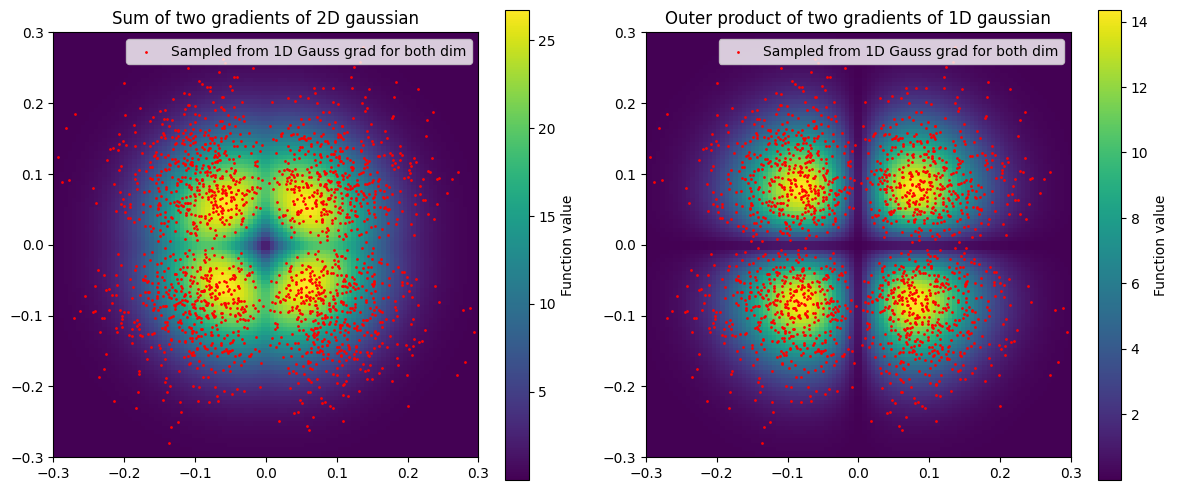

In [6]:
# Test idea 1, sample from sum of the distribution = each dimension is gradient/hessian (similar to michaels)

sigma1 = 0.08

# make the background function
grid_size = 100
x1 = np.linspace(-0.3, 0.3, grid_size)
x2 = np.linspace(-0.3, 0.3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)

# sum of n-d grad shape
grad_gauss_shape_dx = gauss_grad_as_pdf(torch.tensor(x, dtype=torch.float32), sigma=sigma1)[:,0].reshape((grid_size,grid_size))
grad_gauss_shape_dy = gauss_grad_as_pdf(torch.tensor(x, dtype=torch.float32), sigma=sigma1)[:,1].reshape((grid_size,grid_size))
grad_gauss_shape_sum = grad_gauss_shape_dx + grad_gauss_shape_dy

# product of 1-d grad shape
grad_x = gauss_grad_as_pdf(torch.tensor(x1, dtype=torch.float32).unsqueeze(1), sigma=sigma1)
grad_y = gauss_grad_as_pdf(torch.tensor(x2, dtype=torch.float32).unsqueeze(1), sigma=sigma1)
grad_gauss_shape_prod =  grad_x.reshape(-1, 1) @ grad_y.reshape(1, -1)

# dimension-wise shape
n_samples = 1000
x_range = np.linspace(-0.3, 0.3, 1000)
gauss_grad_shape = gauss_grad_as_pdf(torch.tensor(x_range, dtype=torch.float32).unsqueeze(1), sigma=sigma1)
n, tau1, pdf = importance_gradgauss(n_samples, dim=1, sigma=sigma1, is_antithetic=True) # get the samples
n, tau2, pdf = importance_gradgauss(n_samples, dim=1, sigma=sigma1, is_antithetic=True) # get the samples
gauss_values1 = gauss_grad_as_pdf(tau1, sigma=sigma1) # get the samples corresponding y values
gauss_values2 = gauss_grad_as_pdf(tau2, sigma=sigma1) # get the samples corresponding y values
tau_2d = torch.stack([tau2, tau1], dim=1)

# draw
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# cur_ax = ax[0]
# cur_ax.plot(x_range, gauss_grad_shape, label='True gradient')
# cur_ax.scatter(tau1, gauss_values1, s=5, color='blue', label='samples for 1st dim')
# cur_ax.scatter(tau2, gauss_values2, s=5, color='red', label='samples for 2nd dim')
# cur_ax.set_title("PDF for marginalizing xj of 2D gaussian")
# cur_ax.set_xlabel("xj")
# cur_ax.set_ylabel("PDF")

cur_ax = ax[-2]
pcm = cur_ax.pcolor(X1, X2, grad_gauss_shape_sum)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.scatter(tau_2d[:,0], tau_2d[:,1], s=1, color='red', label='Sampled from 1D Gauss grad for both dim')
cur_ax.set_xlim(-0.3, 0.3)
cur_ax.set_ylim(-0.3, 0.3)
cur_ax.set_aspect('equal', adjustable='box')
cur_ax.legend(loc='upper right')
cur_ax.set_title('Sum of two gradients of 2D gaussian')

cur_ax = ax[-1]
pcm = cur_ax.pcolor(X1, X2, grad_gauss_shape_prod)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.scatter(tau_2d[:,0], tau_2d[:,1], s=1, color='red', label='Sampled from 1D Gauss grad for both dim')
cur_ax.set_xlim(-0.3, 0.3)
cur_ax.set_ylim(-0.3, 0.3)
cur_ax.set_aspect('equal', adjustable='box')
cur_ax.legend(loc='upper right')
cur_ax.set_title('Outer product of two gradients of 1D gaussian')

fig.tight_layout()

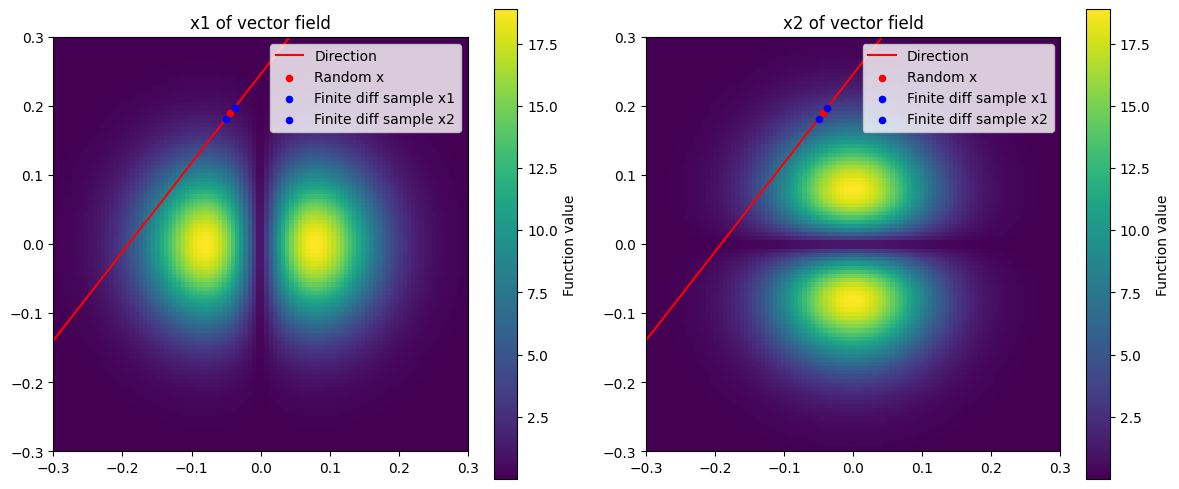

In [18]:
# Hessian, finite difference
dir = torch.rand(2).view(-1, 1)
dir  = dir / dir.norm()
rand_x = torch.rand(2).view(-1, 1) * 0.4 - 0.2
eps = 1e-2
fd_x1 = rand_x + eps*dir
fd_x2 = rand_x - eps*dir

t = torch.linspace(-1,1,100).view(1,-1)
dir_line = rand_x + t*dir
# draw
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


cur_ax = ax[-2]
pcm = cur_ax.pcolor(X1, X2, grad_gauss_shape_dx)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.plot(dir_line[0], dir_line[1], color='red', label='Direction', zorder=2)
cur_ax.scatter(rand_x[0], rand_x[1], s=20, color='red', label='Random x', zorder=3)
cur_ax.scatter(fd_x1[0], fd_x1[1], s=20, color='blue', label='Finite diff sample x1', zorder=3)
cur_ax.scatter(fd_x2[0], fd_x2[1], s=20, color='blue', label='Finite diff sample x2', zorder=3)
cur_ax.set_xlim(-0.3, 0.3)
cur_ax.set_ylim(-0.3, 0.3)
cur_ax.set_aspect('equal', adjustable='box')
cur_ax.legend(loc='upper right')
cur_ax.set_title('x1 of vector field')

cur_ax = ax[-1]
pcm = cur_ax.pcolor(X1, X2, grad_gauss_shape_dy)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_xlim(-0.3, 0.3)
cur_ax.set_ylim(-0.3, 0.3)
cur_ax.set_aspect('equal', adjustable='box')
cur_ax.plot(dir_line[0], dir_line[1], color='red', label='Direction', zorder=2)
cur_ax.scatter(rand_x[0], rand_x[1], s=20, color='red', label='Random x', zorder=3)
cur_ax.scatter(fd_x1[0], fd_x1[1], s=20, color='blue', label='Finite diff sample x1', zorder=3)
cur_ax.scatter(fd_x2[0], fd_x2[1], s=20, color='blue', label='Finite diff sample x2', zorder=3)
cur_ax.legend(loc='upper right')
cur_ax.set_title('x2 of vector field')

fig.tight_layout()

### Testing Michaels' vs Mine

In [46]:
# Sampled convolution results
n_samples=1000
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}
print("With sigma1 = {} and sigma2 = {}".format(sigma1, sigma2))

sampler = 'importance_gradgauss'
sampler_args = {'min': -1, 'max': 1}
sampler_args = {'sigma': sigma2, 'is_antithetic': True}
# sampled gradient with Michael's function
grad = np.zeros((grid_size*grid_size, 2))
for i, point in enumerate(tqdm(x)):
    convolved_value = convolve(gaussian_nd, gauss_grad_1d, torch.tensor(point, dtype=torch.float32).unsqueeze(0), n=n_samples, 
                                sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args)
    grad[i] = convolved_value.detach().numpy()
y0_mi = grad[:,0].reshape((grid_size,grid_size))
y1_mi = grad[:,1].reshape((grid_size,grid_size))

With sigma1 = 0.1 and sigma2 = 0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|          | 57/10000 [00:00<00:17, 569.71it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


  1%|          | 118/10000 [00:00<00:16, 589.82it/s]

3.989422804014327
torch.Size([2000, 2])


  2%|▏         | 180/10000 [00:00<00:16, 599.23it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


  2%|▏         | 241/10000 [00:00<00:16, 603.11it/s]

3.989422804014327
torch.Size([2000, 2])


  3%|▎         | 303/10000 [00:00<00:15, 606.51it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


  4%|▍         | 426/10000 [00:00<00:15, 602.59it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


  5%|▌         | 548/10000 [00:00<00:15, 594.83it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


  7%|▋         | 670/10000 [00:01<00:15, 598.66it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


  8%|▊         | 790/10000 [00:01<00:15, 596.10it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


  9%|▉         | 911/10000 [00:01<00:15, 597.46it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 10%|█         | 1030/10000 [00:01<00:15, 570.29it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 11%|█▏        | 1149/10000 [00:01<00:15, 580.89it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 13%|█▎        | 1269/10000 [00:02<00:14, 587.35it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 14%|█▍        | 1389/10000 [00:02<00:14, 590.76it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 15%|█▌        | 1509/10000 [00:02<00:14, 578.05it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 16%|█▋        | 1629/10000 [00:02<00:14, 585.92it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 17%|█▋        | 1749/10000 [00:02<00:13, 589.89it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 19%|█▊        | 1869/10000 [00:03<00:13, 585.06it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 20%|█▉        | 1988/10000 [00:03<00:13, 587.73it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


 21%|██        | 2067/10000 [00:03<00:13, 589.17it/s]

3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])
3.989422804014327
torch.Size([2000, 2])


KeyboardInterrupt: 

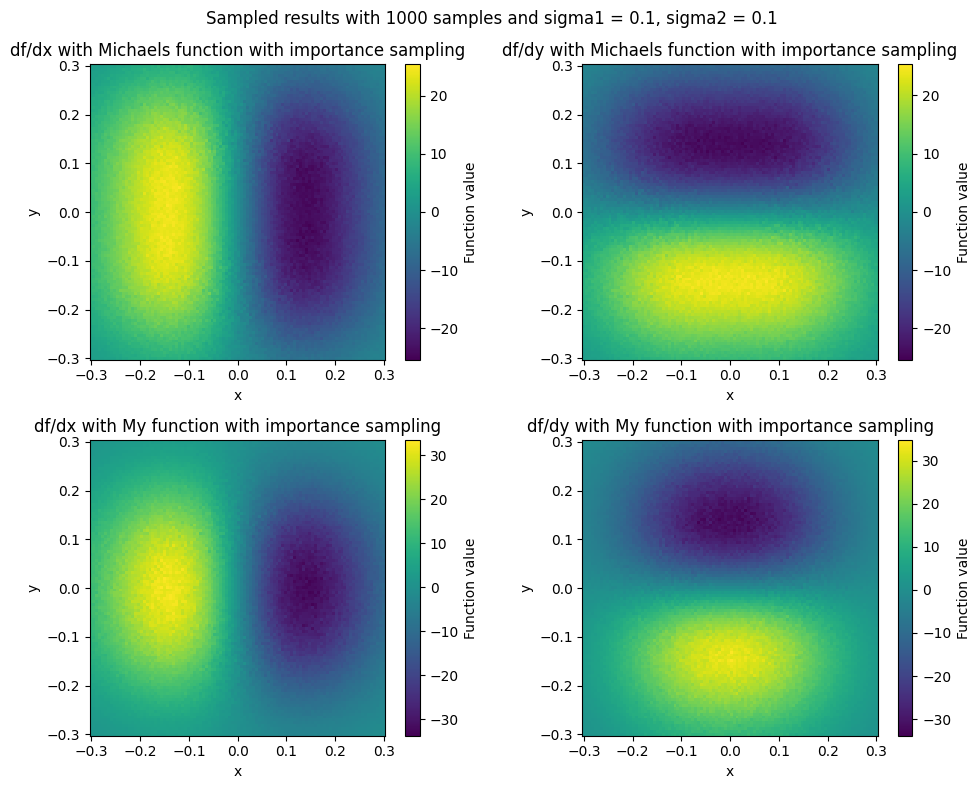

In [237]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

cur_ax = ax[0,0]
pcm = cur_ax.pcolor(X1, X2, y0_mi)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dx with Michaels function with {} sampling'.format(sampler))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

cur_ax = ax[0,1]
pcm = cur_ax.pcolor(X1, X2, y1_mi)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dy with Michaels function with {} sampling'.format(sampler))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

cur_ax = ax[1,0]
pcm = cur_ax.pcolor(X1, X2, y0)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dx with My function with {} sampling'.format(sampler))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

cur_ax = ax[1,1]
pcm = cur_ax.pcolor(X1, X2, y1)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('df/dy with My function with {} sampling'.format(sampler))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

fig.suptitle('Sampled results with {} samples and sigma1 = {}, sigma2 = {}'.format(n_samples, sigma1, sigma2))
fig.tight_layout()
plt.show()

### Variance and bias

In [11]:
def variance(samples, gt, axis=0):
    '''
    samples is nxmxm,
    gt is mxm
    '''
    # broadcast_dims = samples.ndim - 1
    # print(gt.shape, samples.shape, (-1, *(samples.shape[1:])))
    # gt = gt.reshape(-1, *(samples.shape[1:]))
    if axis == 0:
        differences = samples - gt  
    elif axis == 1:
        differences = (samples.T - gt).T
    variances = (differences ** 2).mean(axis=axis)
    return variances
    

In [21]:
min_sample = 1
add_sample = 30
step = 1
number_of_samples = np.arange(min_sample, min_sample+add_sample, step)
samples_length = len(number_of_samples)

sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}

x = torch.tensor([0.3, 0.15], requires_grad=True, device='cpu')
n = 1000 # number of iterations for each point

hess_conv_var_uniform = np.zeros((samples_length, 2, 2))
hess_conv_mean_uniform = np.zeros((samples_length, 2, 2))
hess_conv_var_importance = np.zeros((samples_length, 2, 2))
hess_conv_mean_importance = np.zeros((samples_length, 2, 2))
grad_var_uniform = np.zeros((2, samples_length))
grad_mean_uniform = np.zeros((2, samples_length))
hess_conv_var_grid = np.zeros((samples_length, 2, 2))
hess_conv_mean_grid = np.zeros((samples_length, 2, 2))
grad_var_grid = np.zeros((2, samples_length))
grad_mean_grid = np.zeros((2, samples_length))
grad_var_importance = np.zeros((2, samples_length))
grad_mean_importance = np.zeros((2, samples_length))
mi_grad_var_uniform = np.zeros((2, samples_length))
mi_grad_mean_uniform = np.zeros((2, samples_length))
mi_grad_var_importance = np.zeros((2, samples_length))
mi_grad_mean_importance = np.zeros((2, samples_length))

for i in range(samples_length):
    print("Number of samples: ", number_of_samples[i])
    distribution_hess_uniform = np.zeros((n,2,2))
    distribution_grad_uniform = np.zeros((2, n))
    mi_grad_uniform = np.zeros((2, n))
    distribution_hess_uniform = np.zeros((n,2,2))
    distribution_grad_grid = np.zeros((2, n))
    hess_importance = np.zeros((n,2,2))
    grad_importance = np.zeros((2, n))
    mi_grad_importance = np.zeros((2, n))
    start_time = time.time()
    for j in range(n):
        # uniform samples
        sampler = 'uniform'
        sampler_args = {'min': -1, 'max': 1}
        convolved_value = convolve(gaussian_nd, gauss_hessian_fastest, x.unsqueeze(0), n=number_of_samples[i],
                                    sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args)
        distribution_hess_uniform[j] = convolved_value.detach().numpy() # hessian
        
        distribution_grad_uniform[:, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i],
                                           sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()
        
        # mi_grad_uniform[:, j] = convolve(gaussian_nd, michael_gauss_grad, x.unsqueeze(0), n=number_of_samples[i], 
        #                         sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()
        
        # grid samples
        # sampler = 'grid'
        # sampler_args = {'min': -1, 'max': 1}
        # convolved_value = convolve(gaussian_nd, gauss_hessian_fast, x.unsqueeze(0), n=number_of_samples[i],
        #                             sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args)
        # distribution_hess_uniform[j] = convolved_value.detach().numpy()
        
        # distribution_grad_grid[:, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i],
        #                                    sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()
        # importance samples
        sampler = 'importance_gradgauss'
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':0}
        grad_importance[0, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i],
                                           sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()[0]
        
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':1}
        grad_importance[1, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i],
                                           sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()[1]
        
        sampler = 'importance_hessgauss'
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(0,0)}
        hess_importance[j, 0, 0] = convolve(gaussian_nd, gauss_hessian_fastest, x.unsqueeze(0), n=number_of_samples[i],
                                           sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()[0,0]
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(1,1)}
        hess_importance[j, 1, 1] = convolve(gaussian_nd, gauss_hessian_fastest, x.unsqueeze(0), n=number_of_samples[i],
                                           sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()[1,1]
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(1,0)}
        hess_importance[j, 1, 0] = hess_importance[j, 0, 1] = convolve(gaussian_nd, gauss_hessian_fastest, x.unsqueeze(0), n=number_of_samples[i],
                                           sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()[1,0]
        
        # mi_grad_importance[:, j] = convolve(gaussian_nd, michael_gauss_grad, x.unsqueeze(0), n=number_of_samples[i], 
        #                         sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args).detach().numpy()
        
    print("Time taken: ", time.time()-start_time)
    # hess_conv_var_uniform[i, :, :] = np.var(distribution_hess_uniform, axis=0)
    hess_conv_mean_uniform[i, :, :] = np.mean(distribution_hess_uniform, axis=0)
    hess_conv_var_uniform[i, :, :] = variance(distribution_hess_uniform, hess_conv_mean_uniform[i,:,:], axis=0)
    
    hess_conv_mean_importance[i, :, :] = np.mean(hess_importance, axis=0)
    hess_conv_var_importance[i, :, :] = variance(hess_importance, hess_conv_mean_importance[i,:,:], axis=0)
    
    # hess_conv_var_grid[i, :, :] = np.var(distribution_hess_uniform, axis=0)
    # hess_conv_mean_grid[i, :, :] = np.mean(distribution_hess_uniform, axis=0)
    # grad_var_uniform[:, i] = np.var(distribution_grad_uniform, axis=1)
    grad_mean_uniform[:, i] = np.mean(distribution_grad_uniform, axis=1)
    grad_var_uniform[:, i] = variance(distribution_grad_uniform, grad_mean_uniform[:,i], axis=1)
    # grad_var_grid[:, i] = np.var(distribution_grad_grid, axis=1)
    # grad_var_grid[:, i] = np.var(distribution_grad_grid, axis=1)
    # grad_mean_grid[:, i] = np.mean(distribution_grad_grid, axis=1)
    # grad_var_importance[:, i] = np.var(grad_importance, axis=1)
    grad_mean_importance[:, i] = np.mean(grad_importance, axis=1)
    grad_var_importance[:, i] = variance(grad_importance, grad_mean_importance[:,i], axis=1)
    # mi_grad_var_uniform[:, i] = np.var(mi_grad_uniform, axis=1)
    mi_grad_mean_uniform[:, i] = np.mean(mi_grad_uniform, axis=1)
    mi_grad_var_uniform[:, i] = variance(mi_grad_uniform, mi_grad_mean_uniform[:,i], axis=1)
    # mi_grad_var_importance[:, i] = np.var(mi_grad_importance, axis=1)
    mi_grad_mean_importance[:, i] = np.mean(mi_grad_importance, axis=1)
    mi_grad_var_importance[:, i] = variance(mi_grad_importance, mi_grad_mean_importance[:,i], axis=1)
    


Number of samples:  1
Time taken:  6.938290596008301
Number of samples:  2
Time taken:  7.007533311843872
Number of samples:  3
Time taken:  7.0679771900177
Number of samples:  4
Time taken:  7.042536020278931
Number of samples:  5
Time taken:  7.055883169174194
Number of samples:  6
Time taken:  7.050718069076538
Number of samples:  7
Time taken:  7.053583145141602
Number of samples:  8
Time taken:  7.062303304672241
Number of samples:  9
Time taken:  7.102925062179565
Number of samples:  10
Time taken:  7.11379075050354
Number of samples:  11
Time taken:  7.130757808685303
Number of samples:  12
Time taken:  7.151626825332642
Number of samples:  13
Time taken:  7.114416122436523
Number of samples:  14
Time taken:  7.205702304840088
Number of samples:  15
Time taken:  7.1850128173828125
Number of samples:  16
Time taken:  7.1869683265686035
Number of samples:  17
Time taken:  7.237040758132935
Number of samples:  18
Time taken:  7.179754972457886
Number of samples:  19
Time taken:  7.

In [22]:
# compute true grad and hess
new_sigma = (sigma1**2 + sigma2**2)**0.5
diff = gauss_grad(x.clone().detach().unsqueeze(0), new_sigma)
hess_non_diag = gauss_hessian_fast(x.clone().detach().unsqueeze(0), new_sigma)
diff = np.tile(diff, (samples_length, 1))
hess_non_diag = np.tile(hess_non_diag, (samples_length, 1, 1))


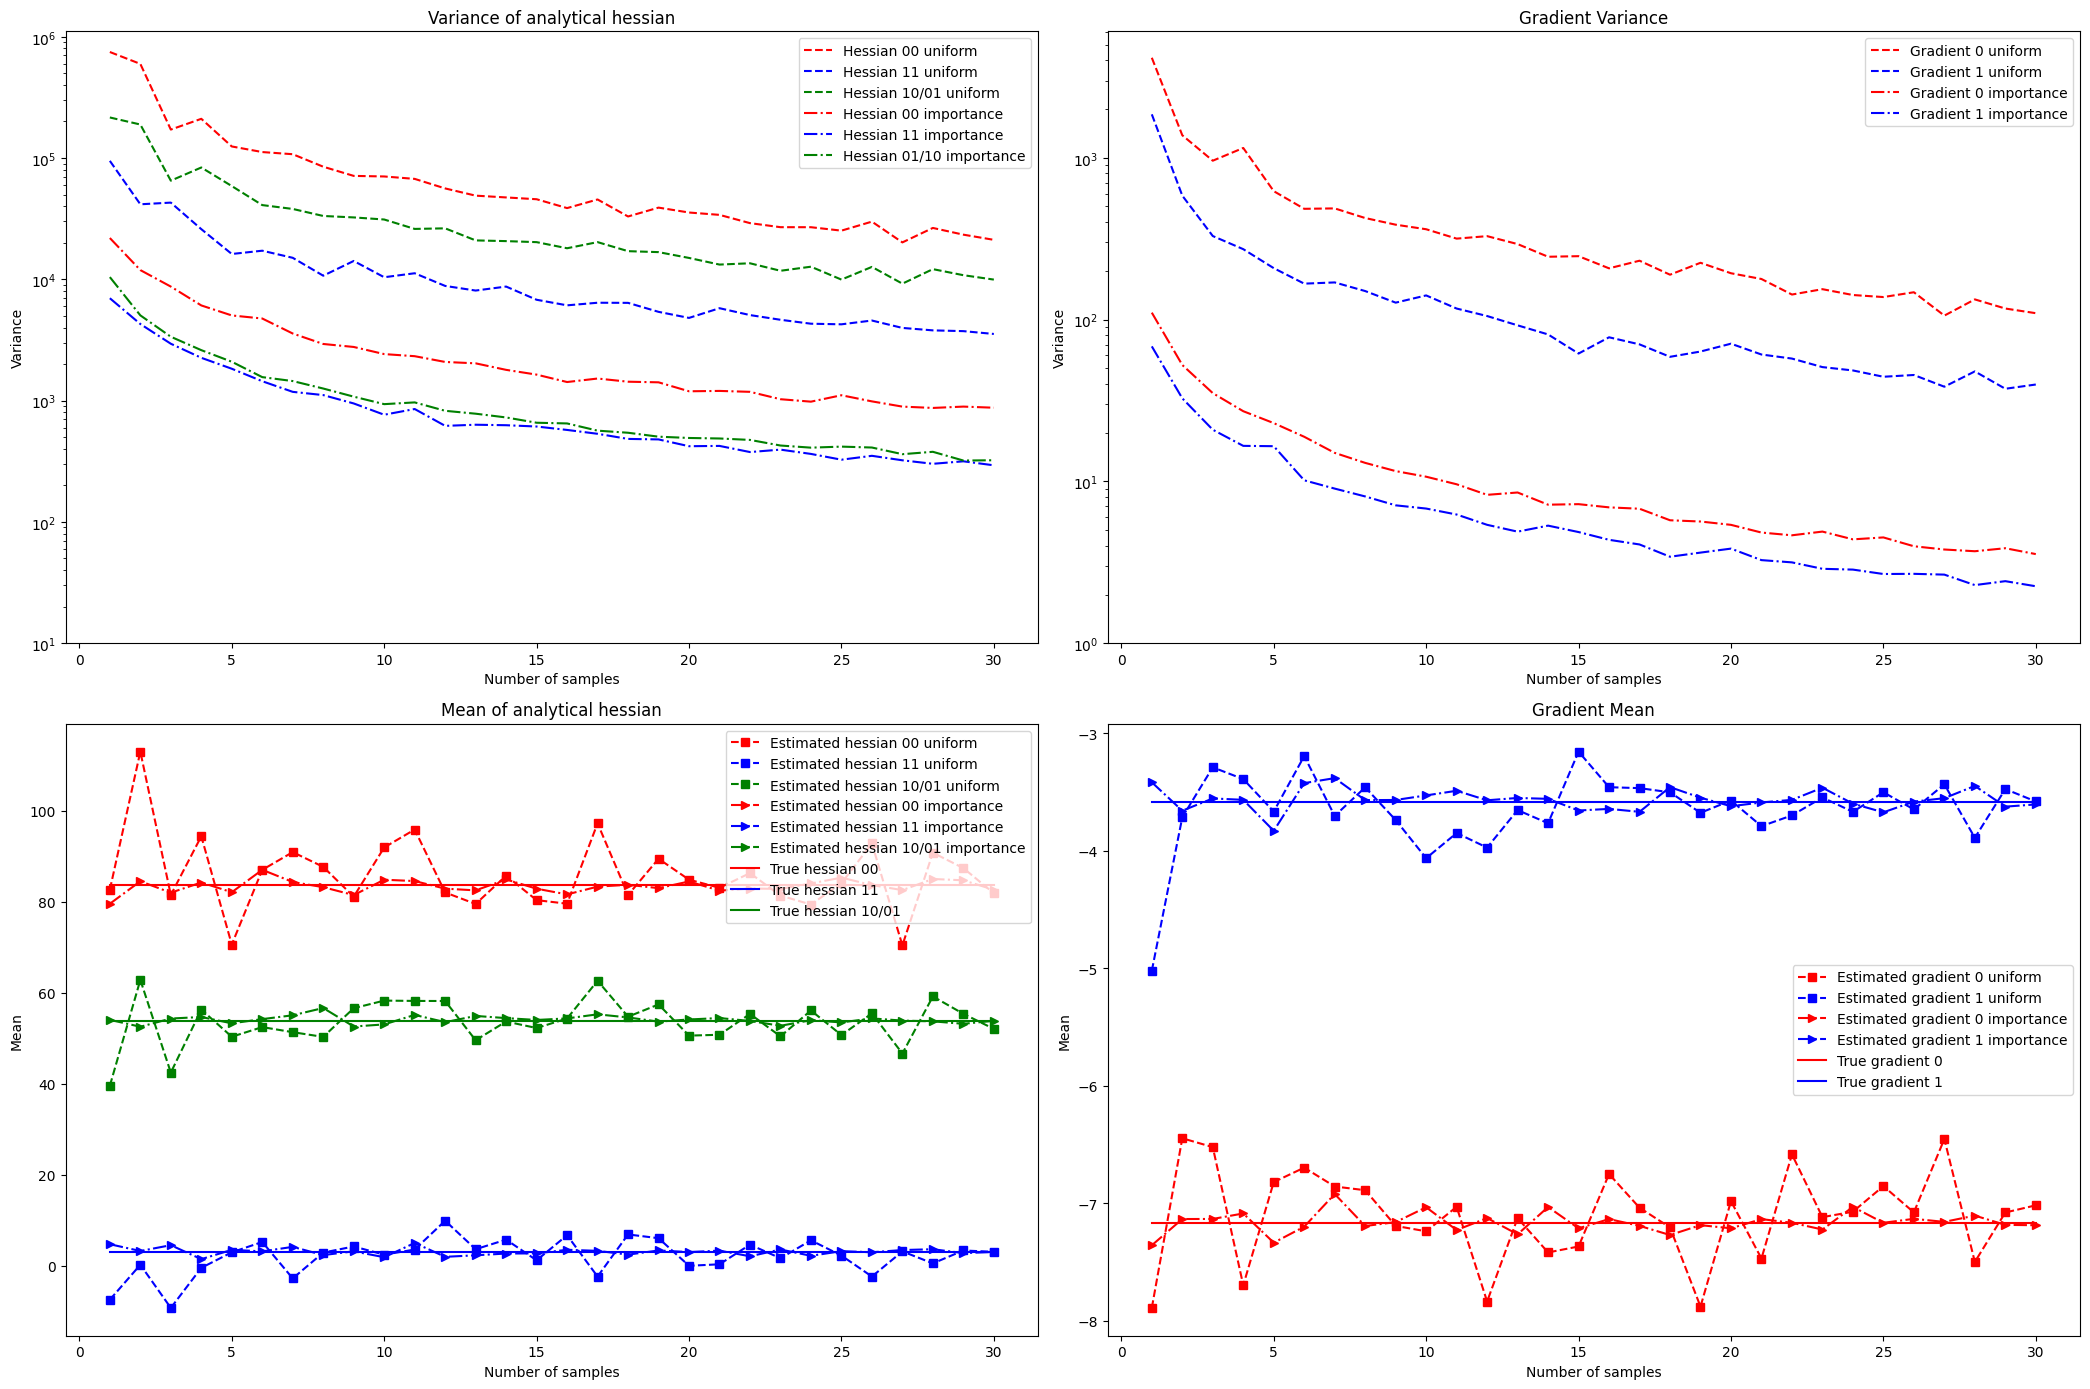

In [23]:
plt.figure(figsize=(21,14))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var_uniform[:,0,0], color='red', linestyle='--', label="Hessian 00 uniform")
plt.plot(number_of_samples, hess_conv_var_uniform[:,1,1], color='blue', linestyle='--', label="Hessian 11 uniform")
plt.plot(number_of_samples, hess_conv_var_uniform[:,1,0], color='green', linestyle='--', label="Hessian 10/01 uniform")
plt.plot(number_of_samples, hess_conv_var_importance[:,0,0], color='red', linestyle='-.', label="Hessian 00 importance")
plt.plot(number_of_samples, hess_conv_var_importance[:,1,1], color='blue', linestyle='-.', label="Hessian 11 importance")
plt.plot(number_of_samples, hess_conv_var_importance[:,0,1], color='green', linestyle='-.', label="Hessian 01/10 importance")
# plt.plot(number_of_samples, hess_conv_var_grid[:,0,0], color='red', linestyle='-.', label="Hessian 00 grid")
# plt.plot(number_of_samples, hess_conv_var_grid[:,1,1], color='blue', linestyle='-.', label="Hessian 11 grid")
# plt.plot(number_of_samples, hess_conv_var_grid[:,1,0], color='green', linestyle='-.', label="Hessian 10/01 grid")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.yscale('log')
plt.ylim(bottom=10)
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var_uniform[0,:], color='red', linestyle='--', label="Gradient 0 uniform")
plt.plot(number_of_samples, grad_var_uniform[1,:], color='blue', linestyle='--', label="Gradient 1 uniform")
# plt.plot(number_of_samples, grad_var_grid[0,:], color='red', linestyle='-.', label="Gradient 0 grid")
# plt.plot(number_of_samples, grad_var_grid[1,:], color='blue', linestyle='-.', label="Gradient 1 grid")
plt.plot(number_of_samples, grad_var_importance[0,:], color='red', linestyle='-.', label="Gradient 0 importance")
plt.plot(number_of_samples, grad_var_importance[1,:], color='blue', linestyle='-.', label="Gradient 1 importance")
# plt.plot(number_of_samples, mi_grad_var_uniform[0,:], color='red', linestyle=':', label="Michael's gradient 0 uniform")
# plt.plot(number_of_samples, mi_grad_var_uniform[1,:], color='blue', linestyle=':', label="Michael's gradient 1 uniform")
# plt.plot(number_of_samples, mi_grad_var_importance[0,:], color='red', linestyle='--', marker='o', label="Michael's gradient 0 importance")
# plt.plot(number_of_samples, mi_grad_var_importance[1,:], color='blue', linestyle='--', marker='o', label="Michael's gradient 1 importance")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.yscale('log')
plt.ylim(bottom=1)
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean_uniform[:,0,0], color='red', linestyle='--', marker='s', label="Estimated hessian 00 uniform")
plt.plot(number_of_samples, hess_conv_mean_uniform[:,1,1], color='blue', linestyle='--', marker='s', label="Estimated hessian 11 uniform")
plt.plot(number_of_samples, hess_conv_mean_uniform[:,1,0], color='green', linestyle='--', marker='s', label="Estimated hessian 10/01 uniform")
plt.plot(number_of_samples, hess_conv_mean_importance[:,0,0], color='red', linestyle='-.', marker='>', label="Estimated hessian 00 importance")
plt.plot(number_of_samples, hess_conv_mean_importance[:,1,1], color='blue', linestyle='-.', marker='>', label="Estimated hessian 11 importance")
plt.plot(number_of_samples, hess_conv_mean_importance[:,1,0], color='green', linestyle='-.', marker='>', label="Estimated hessian 10/01 importance")
# plt.plot(number_of_samples, hess_conv_mean_grid[:,0,0], color='red', linestyle='-.', marker='>', label="Estimated hessian 00 grid")
# plt.plot(number_of_samples, hess_conv_mean_grid[:,1,1], color='blue', linestyle='-.', marker='>', label="Estimated hessian 11 grid")
# plt.plot(number_of_samples, hess_conv_mean_grid[:,1,0], color='green', linestyle='-.', marker='>', label="Estimated hessian 10/01 grid")
plt.plot(number_of_samples, hess_non_diag[:,0,0], color='red', label="True hessian 00")
plt.plot(number_of_samples, hess_non_diag[:,1,1], color='blue', label="True hessian 11")
plt.plot(number_of_samples, hess_non_diag[:,1,0], color='green', label="True hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean_uniform[0,:], color='red', linestyle='--', marker='s', label="Estimated gradient 0 uniform")
plt.plot(number_of_samples, grad_mean_uniform[1,:], color='blue', linestyle='--', marker='s', label="Estimated gradient 1 uniform")
# plt.plot(number_of_samples, grad_mean_grid[0,:], color='red', linestyle='-.', marker='>', label="Estimated gradient 0 grid")
# plt.plot(number_of_samples, grad_mean_grid[1,:], color='blue', linestyle='-.', marker='>', label="Estimated gradient 1 grid")
plt.plot(number_of_samples, grad_mean_importance[0,:], color='red', linestyle='-.', marker='>', label="Estimated gradient 0 importance")
plt.plot(number_of_samples, grad_mean_importance[1,:], color='blue', linestyle='-.', marker='>', label="Estimated gradient 1 importance")
# plt.plot(number_of_samples, mi_grad_mean_uniform[0,:], color='red', linestyle=':', label="Michael's gradient 0 uniform")
# plt.plot(number_of_samples, mi_grad_mean_uniform[1,:], color='blue', linestyle=':', label="Michael's gradient 1 uniform")
# plt.plot(number_of_samples, mi_grad_mean_importance[0,:], color='red', linestyle='--', marker='o', label="Michael's gradient 0 importance")
# plt.plot(number_of_samples, mi_grad_mean_importance[1,:], color='blue', linestyle='--', marker='o', label="Michael's gradient 1 importance")
plt.plot(number_of_samples, diff[:,0], color='red', label="True gradient 0")
plt.plot(number_of_samples, diff[:,1], color='blue', label="True gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()


## others

### Experiments for IS hessian

#### Diagonal

In [8]:
from scipy.optimize import fsolve
def inverse_cdf_2nd_gauss(y, sigma):
    def func(x):
        return gauss_grad_1d_as_cdf(x, sigma, no_pos=True)
    if y <= 0.25:
        result = fsolve(lambda x: func(x) - y, -2*sigma)
        # print("First: ", result)
    elif (y > 0.25) & (y <= 0.75):
        result = fsolve(lambda x: 0.5-func(x)-y, 0)
        # print("Second: ", result)
    else:
        result = fsolve(lambda x: 1+func(x)-y, 2*sigma)
        # print("Third: ", result)
    return result[0]


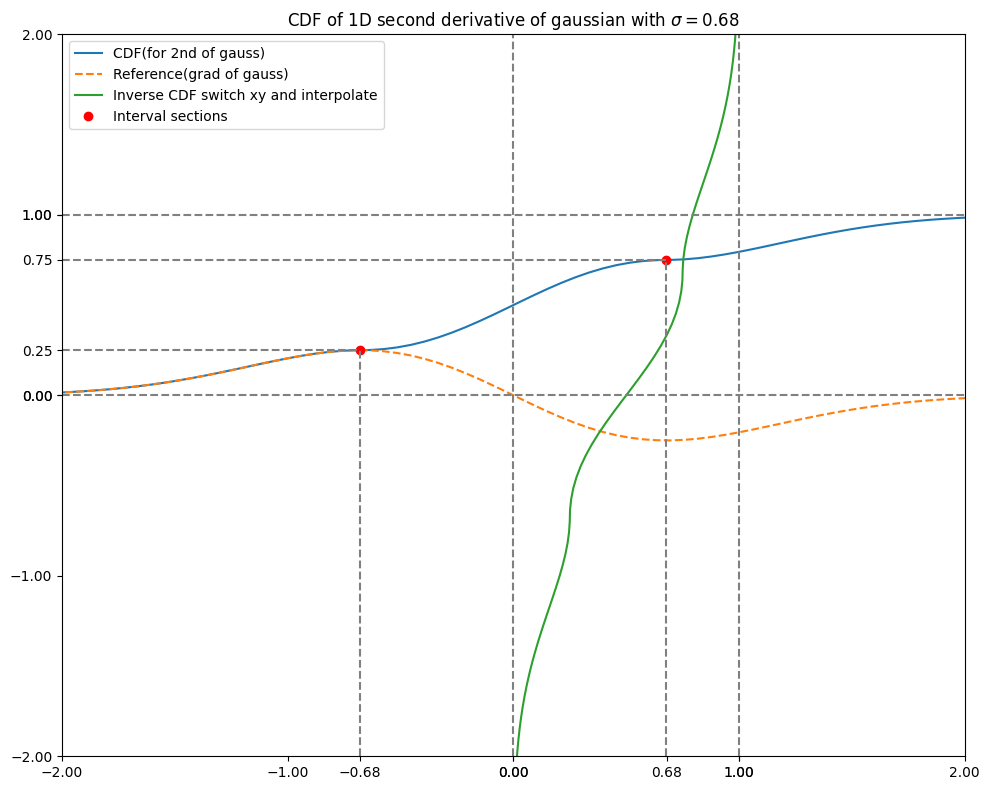

In [24]:
sigma = torch.rand(1) * 0.4 + 0.3
x_range = torch.linspace(-3, 3, 100)
reference_x_values = [-sigma.item(), sigma.item()]
reference_y_values = [gauss_grad_1d_as_cdf(x=x, sigma=sigma).item() for x in reference_x_values]
# icdf_y_range = torch.linspace(0.001, 0.999, 1000)
# inverse_lookup = np.array([inverse_cdf_2nd_gauss(y, sigma) for y in icdf_y_range])

_, samples = importance_hessgauss(1000, 1, sigma=sigma.item(), is_antithetic=True)
    

eps = 0.0001
randoms = torch.rand(n_samples, dim)
icdf = inverse_cdf_hess(sigma.item())

# avoid NaNs bc of numerical instabilities in log
randoms[torch.isclose(randoms, torch.ones_like(randoms))] -= eps
randoms[torch.isclose(randoms, torch.zeros_like(randoms))] += eps
# randoms[torch.isclose(randoms, torch.full_like(randoms, fill_value=0.5))] += eps
# randoms[torch.isclose(randoms, torch.full_like(randoms, fill_value=-0.5))] -= eps

samples = icdf(randoms)
    
    

cdf = gauss_grad_1d_as_cdf(x=x_range, sigma=sigma)
reference = gauss_grad_1d_as_cdf(x_range, sigma, no_pos=True)

figure_lims = (-2, 2)
plt.figure(figsize=(10, 8))
plt.plot(x_range, cdf, label='CDF(for 2nd of gauss)')
plt.plot(x_range, reference, linestyle='--', label='Reference(grad of gauss)')    
plt.plot(cdf, icdf(cdf), label='Inverse CDF switch xy and interpolate')
# plt.plot(icdf_y_range, inverse_lookup, linestyle='--', label='Inverse CDF(root finding)')
plt.plot(reference_x_values, reference_y_values, 'ro', label='Interval sections')
# plt.scatter(samples, gauss_grad_1d_as_cdf(samples, sigma), s=5, color='red', label='Samples')
# set reference values as ticks
for i, x_val in enumerate(reference_x_values):
    plt.plot([x_val, x_val], [figure_lims[0], reference_y_values[i]], color='gray', linestyle='--')
for i, y_val in enumerate(reference_y_values):
    plt.plot([figure_lims[0], reference_x_values[i]], [y_val, y_val], color='gray', linestyle='--')
    
# do 0 and 1 lims reference line by hand:
reference_y_values.extend([0.0, 1.0])
reference_x_values.extend([0.0, 1.0])
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.axhline(1.0, color='gray', linestyle='--')
plt.axvline(1.0, color='gray', linestyle='--')
yticks = plt.yticks()[0].tolist()
yticks.extend(reference_y_values)
plt.yticks(sorted(yticks))

xticks = plt.xticks()[0].tolist()
xticks.extend([round(x, 2) for x in reference_x_values])
xticks = sorted(xticks)
plt.xticks(xticks)
plt.xlim(figure_lims)
plt.ylim(figure_lims)
plt.title("CDF of 1D second derivative of gaussian with $\sigma={:.2f}$".format(sigma.item()))
plt.legend()
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Second order derivative of gaussian with $\\sigma=0.68$')

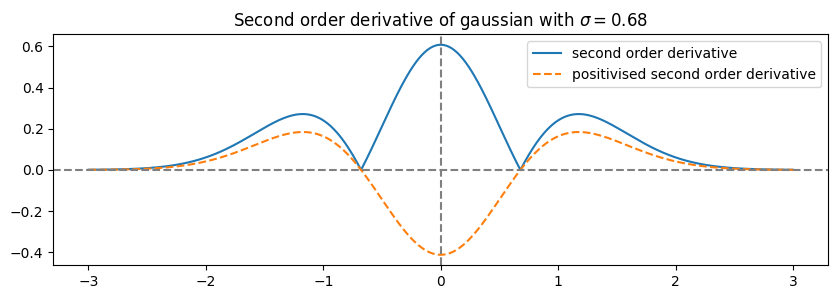

In [25]:
x_range = torch.linspace(-3, 3, 500)
pdf_nopos = gauss_hessian_as_pdf_nopos(x_range.unsqueeze(1), sigma=sigma)
pdf = gauss_hessian_as_pdf(x_range.unsqueeze(1), sigma=sigma)

figure_lims = (-2, 2)
plt.figure(figsize=(10, 3))
plt.plot(x_range, pdf[:,0], label='second order derivative')
plt.plot(x_range, pdf_nopos[:,0], label='positivised second order derivative', linestyle='--')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.legend()
plt.title("Second order derivative of gaussian with $\sigma={:.2f}$".format(sigma.item()))

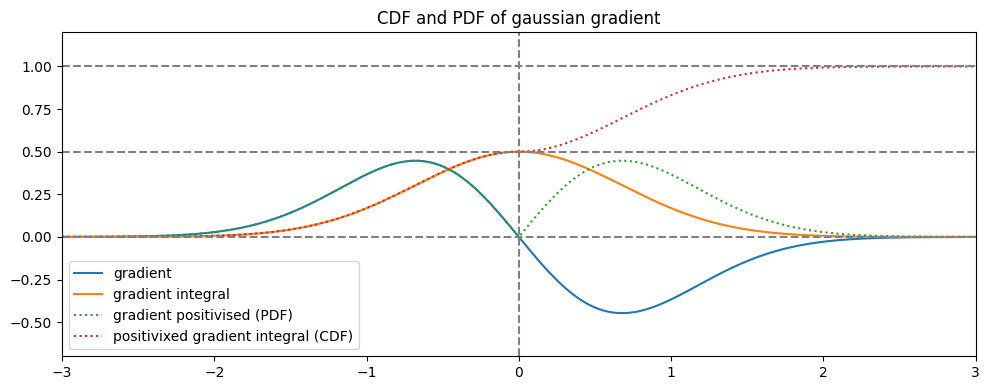

In [26]:
x_range = torch.linspace(-3, 3, 1000)
grad_cdf = gauss_1d_as_cdf(x_range.unsqueeze(0), sigma=sigma, no_pos=False)
grad_cdf_nopos = gauss_1d_as_cdf(x_range.unsqueeze(0), sigma=sigma, no_pos=True)
grad_pdf = gauss_grad_as_pdf(x_range.unsqueeze(-1), sigma=sigma)
grad_pdf_nopos = gauss_grad_as_pdf(x_range.unsqueeze(-1), sigma=sigma, no_pos=True)
# hessian_pdf = gauss_hess_diag_as_pdf(x_range.unsqueeze(-1), sigma=sigma)

plt.figure(figsize=(10, 4))
plt.plot(x_range, grad_pdf_nopos, label='gradient')
# plt.plot(x_range, hessian_pdf, linestyle='--', label=' 2nd derivative pdf') 
plt.plot(x_range, grad_cdf_nopos.T, label= 'gradient integral')
plt.plot(x_range, grad_pdf, label='gradient positivised (PDF)', linestyle=':')
plt.plot(x_range, grad_cdf.T, label='positivixed gradient integral (CDF)', linestyle=':')

plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.axhline(1.0, color='gray', linestyle='--')
plt.axhline(0.5, color='gray', linestyle='--')

plt.xlim((-3, 3))
plt.ylim((-0.7, 1.2))
# plt.title("PDF of 1D second derivative of gaussian with $\sigma={:.2f}$".format(sigma.item()))
plt.title('CDF and PDF of gaussian gradient')
plt.legend()
plt.tight_layout()
plt.show()


#### Nondiagonal

torch.Size([10000, 2, 2])


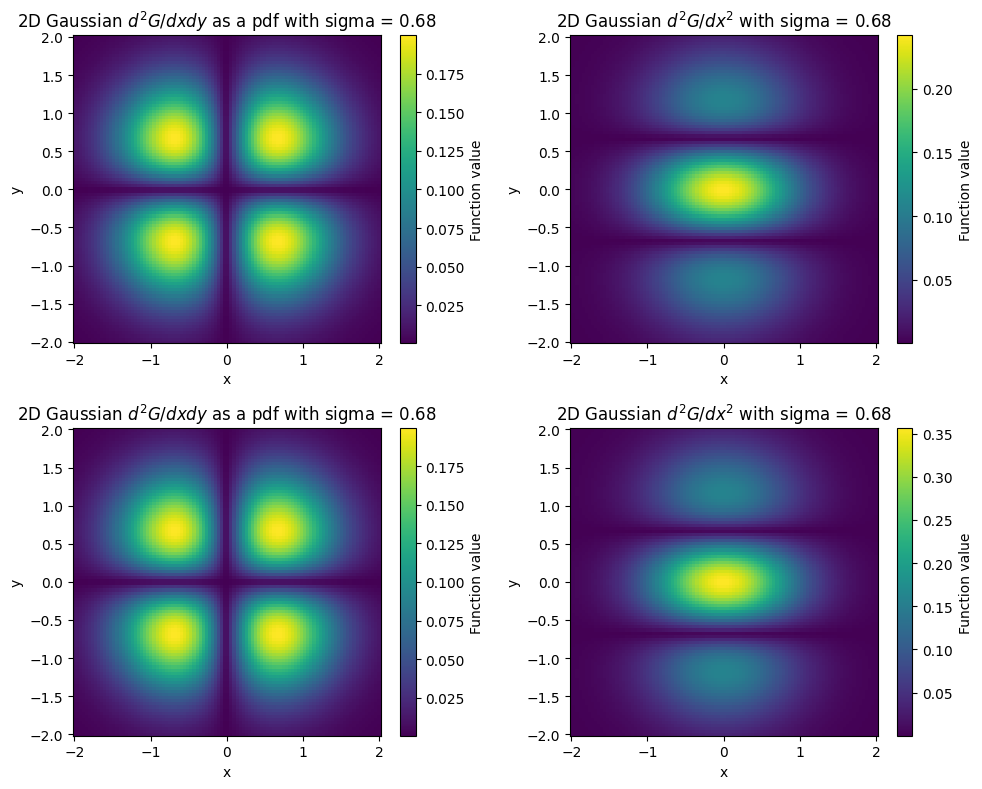

In [28]:
grid_size = 100
x1 = np.linspace(-2, 2, grid_size)
x2 = np.linspace(-2, 2, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)


hess_non_diag = gauss_hess_non_diag_pdf(torch.tensor(x), sigma)[:,1,0].reshape((grid_size, grid_size)) # only take non-diag
hessian_diag = gauss_hess_diag_as_pdf(torch.tensor(x), sigma=sigma)[:, 1].reshape((grid_size, grid_size)) #0 and 1 means 00 and 11 diagonal


hessian_newf = gauss_hessian_as_pdf(torch.tensor(x, dtype=torch.float32), sigma=sigma) # new combined function test

print(hessian_newf.shape)
fig, ax = plt.subplots(2, 2,figsize=(10, 8))

cur_ax = ax[0,0]
pcm = cur_ax.pcolor(X1, X2, hess_non_diag)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('2D Gaussian $d^2G/dxdy$ as a pdf with sigma = {:.2f}'.format(sigma.item()))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[0,1]
pcm = cur_ax.pcolor(X1, X2, hessian_diag)
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('2D Gaussian $d^2G/dx^2$ with sigma = {:.2f}'.format(sigma.item()))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')

cur_ax = ax[1,0]
pcm = cur_ax.pcolor(X1, X2, hessian_newf[:,1,0].reshape((grid_size, grid_size)))
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('2D Gaussian $d^2G/dxdy$ as a pdf with sigma = {:.2f}'.format(sigma.item()))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')


cur_ax = ax[1,1]
pcm = cur_ax.pcolor(X1, X2, hessian_newf[:,1,1].reshape((grid_size, grid_size)))
cbar = fig.colorbar(pcm, ax=cur_ax)
cbar.set_label('Function value')
cur_ax.set_title('2D Gaussian $d^2G/dx^2$ with sigma = {:.2f}'.format(sigma.item()))
cur_ax.set_xlabel('x')
cur_ax.set_ylabel('y')
cur_ax.set_aspect('equal', adjustable='box')
fig.tight_layout()


In [103]:
print(torch.rand(10,0))

tensor([], size=(10, 0))


#### on rosenbrock

In [3]:
# 2d Rosenbrock function
def f(x, a=1.0, b=100.0):
    '''
    x: array of row vector of size 2
    '''
    # print(x)
    return (a - x[:,0])**2 + b * (x[:,1] - x[:,0]**2)**2

def df(x, a=1.0, b=100.0):
    '''
    for 2d x
    '''
    dx1 = -2*(a-x[:,0]) - 4*b*x[:,0] * (x[:,1]-x[:,0]**2)
    dx2 = 2*b*(x[:,1] - x[:,0]**2)
    return torch.tensor([dx1, dx2]).unsqueeze(0)

def hf(x, a=1.0, b=100.0):
    dx11 = 2 - 4*b*x[:,1] + 12*b*x[:,0]
    dx12 = -4*b*x[:,0]
    dx22 = 2*b
    
    dx11 = dx11.view(-1,1)
    dx12 = dx12.view(-1,1)
    first_column = torch.stack((dx11, dx12), dim=-1)
    second_column = torch.stack((dx12, torch.full_like(dx12, dx22)), dim=-1)
    hessian = torch.stack((first_column, second_column), dim=-2)
    return hessian.squeeze()

In [ ]:
grid_size = 200
x1 = np.linspace(-2, 2, grid_size)
x2 = np.linspace(-1, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)

y = f(x).reshape((grid_size,grid_size))

fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)
# ax.clabel(contours, inline=True, fontsize=8)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()